#### Importing Library

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
# import dtreeviz 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point
from matplotlib.lines import Line2D
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

C:\Users\lidou\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Constant

In [2]:
area_interval = 100 #meters

#### Traffic Cameras - may not useful

In [3]:
# # Load the JSON data from the given URL
# url = "Traffic_Cameras_20240306.csv"
# data_traffic_cameras = pd.read_csv(url)

# data_traffic_cameras['geometry'] = data_traffic_cameras['Point'].apply(wkt.loads)
# data_traffic_cameras = gpd.GeoDataFrame(data_traffic_cameras, geometry='geometry')
# data_traffic_cameras.set_crs(epsg=4326, inplace=True)
# data_traffic_cameras = data_traffic_cameras.to_crs(epsg=32612)

# # Display the first few rows of the GeoDataFrame to verify
# display(data_traffic_cameras.head())
# display(data_traffic_cameras.info())

# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# data_traffic_cameras.plot(ax=ax, color='red', linewidth=1, label='Traffic Cameras Network')

# plt.legend()
# plt.show()

#### Neighbourhood Speed Limit  - may not useful

SEGMENT_ID BUILT_STATUS       FULL_NAME  SPEED_LIMIT           CTP_CLASS  \
0      100019        Built  DEERVIEW WY SE         40.0  Residential Street   
1      100020        Built  DEERVIEW WY SE         40.0  Residential Street   
2      100022        Built  DEERVIEW CO SE         40.0  Residential Street   
3      100023        Built  DEERVIEW CO SE         40.0  Residential Street   
4      100025        Built  DEERVIEW WY SE         40.0  Residential Street   

                                     MULTILINESTRING  \
0  MULTILINESTRING ((-114.0223844 50.9308032, -11...   
1  MULTILINESTRING ((-114.0228964 50.9307993, -11...   
2  MULTILINESTRING ((-114.0224186 50.929966, -114...   
3  MULTILINESTRING ((-114.0229359 50.9299765, -11...   
4  MULTILINESTRING ((-114.0222637 50.9288754, -11...   

                                            geometry  
0  MULTILINESTRING ((287625.389 5646480.682, 2875...  
1  MULTILINESTRING ((287589.401 5646481.723, 2875...  
2  MULTILINESTRING ((287619.171 5646387.709, 2875...  
3  MULTILINESTRING ((287582.876 5646390.366, 2875...  
4  MULTILINESTRING ((287625.083 5646266.020, 2876...

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 73038 entries, 0 to 73037
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SEGMENT_ID       73038 non-null  int64   
 1   BUILT_STATUS     73038 non-null  object  
 2   FULL_NAME        73026 non-null  object  
 3   SPEED_LIMIT      54432 non-null  float64 
 4   CTP_CLASS        73038 non-null  object  
 5   MULTILINESTRING  73038 non-null  object  
 6   geometry         73038 non-null  geometry
dtypes: float64(1), geometry(1), int64(1), object(4)
memory usage: 3.9+ MB


None

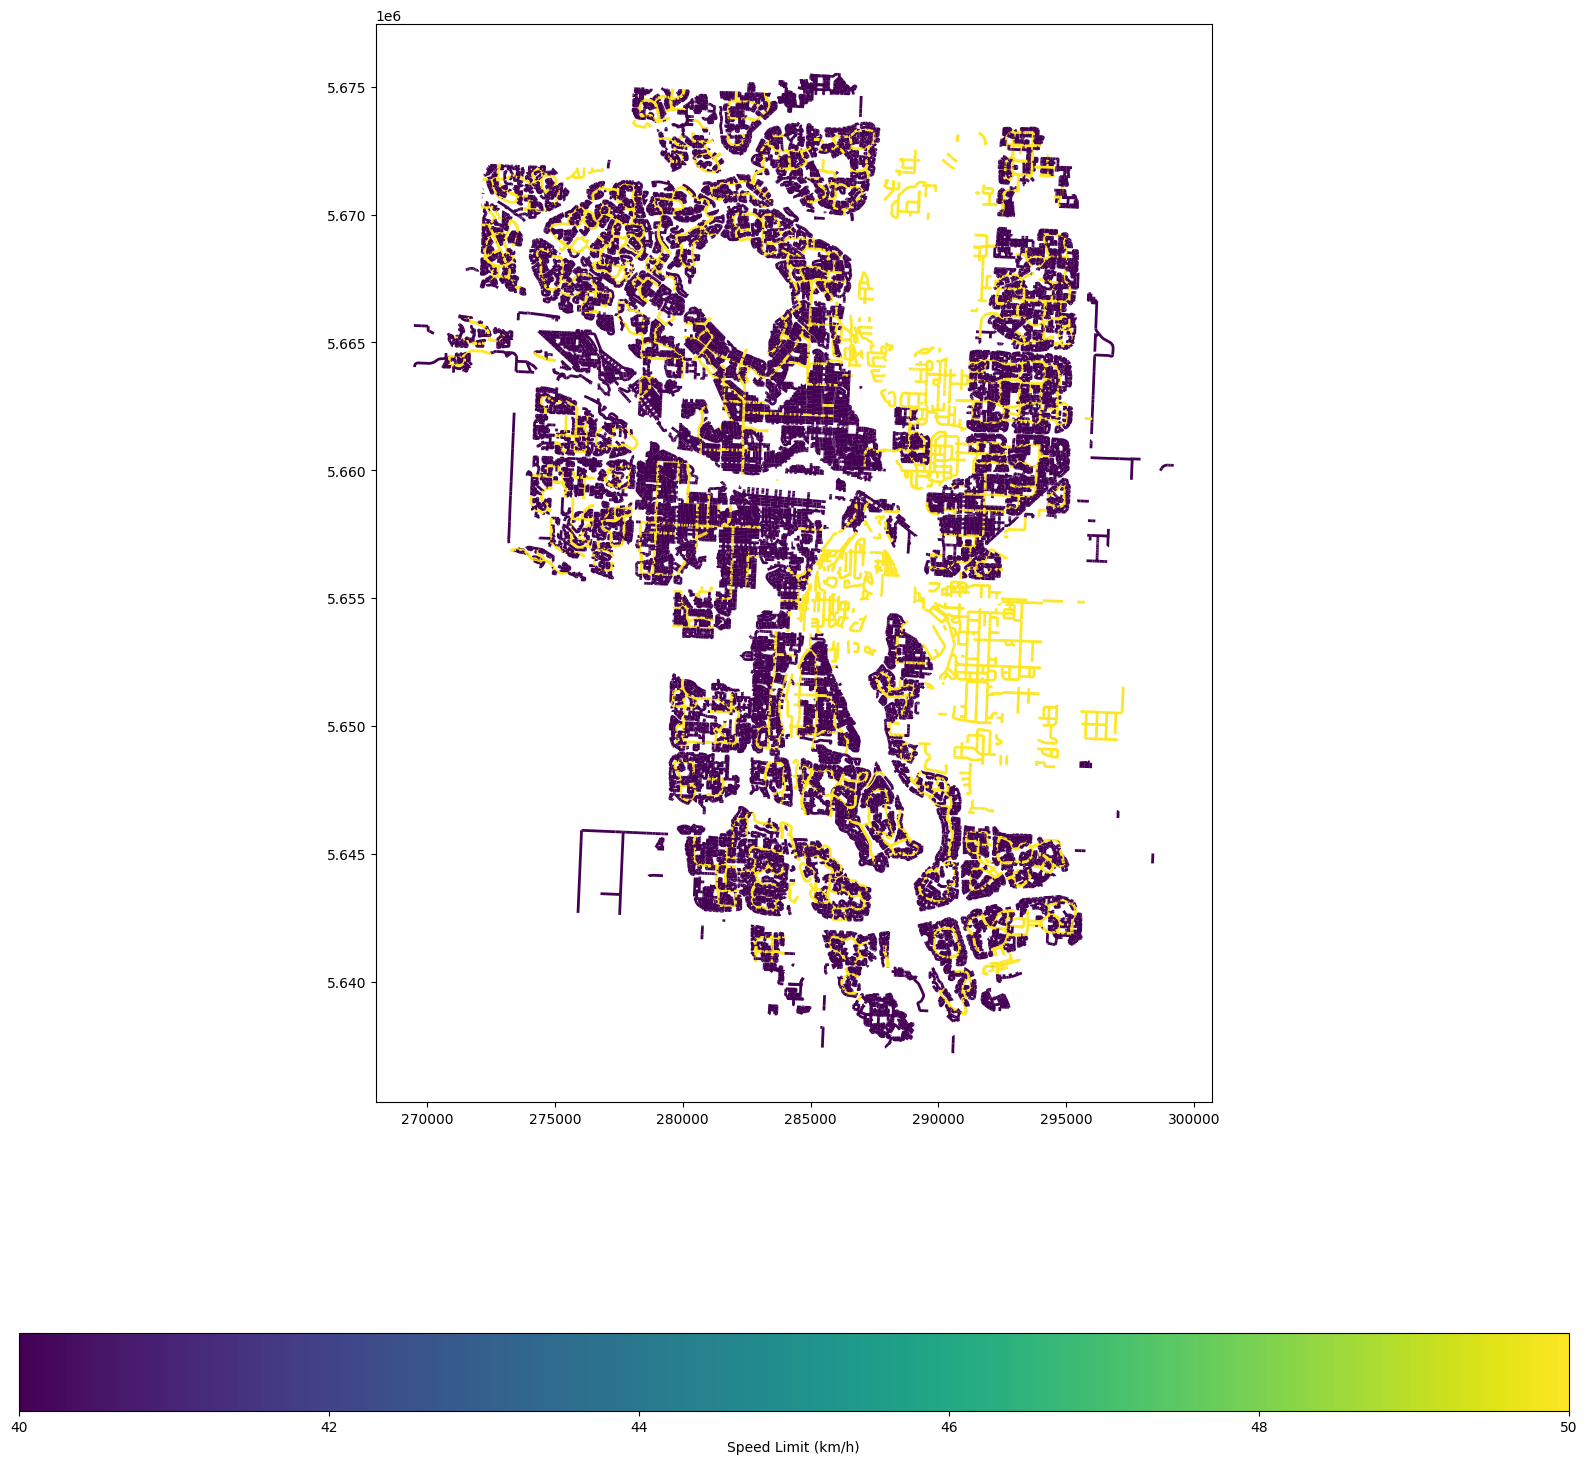

In [4]:
# Load the JSON data from the given URL
url = "Neighbourhood_Speed_Limits_20240306.csv"
data_neighbourhood_speed_limits = pd.read_csv(url)

data_neighbourhood_speed_limits['geometry'] = data_neighbourhood_speed_limits['MULTILINESTRING'].apply(wkt.loads)
data_neighbourhood_speed_limits = gpd.GeoDataFrame(data_neighbourhood_speed_limits, geometry='geometry')
data_neighbourhood_speed_limits.set_crs(epsg=4326, inplace=True)
data_neighbourhood_speed_limits = data_neighbourhood_speed_limits.to_crs(epsg=32612)

data_neighbourhood_speed_limits['SPEED_LIMIT'] = pd.to_numeric(data_neighbourhood_speed_limits['SPEED_LIMIT'].str.replace(' km/h', ''), errors='coerce')

# Display the first few rows of the DataFrame to verify
display(data_neighbourhood_speed_limits.head())
display(data_neighbourhood_speed_limits.info())

fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
data_neighbourhood_speed_limits.plot(
    ax=ax,
    column='SPEED_LIMIT',  # Specify the column based on which to vary colors
    linewidth=2,
    legend=True,  # Add a legend
    cmap='viridis',  # Specify a colormap
    legend_kwds={
        'label': "Speed Limit (km/h)",
        'orientation': "horizontal"
    }
)

plt.show()

In [5]:
# Sampling 1/100 records randomly
sampled_df = data_neighbourhood_speed_limits.sample(n=int(len(data_neighbourhood_speed_limits)/100), random_state=1)  # Fixed random state for reproducibility

# Save the sampled data to a CSV file
sampled_file_path = 'Neighbourhood_Speed_Limits_small.csv'
sampled_df.to_csv(sampled_file_path, index=False)

# Return the path to the saved CSV file for download
sampled_file_path

'Neighbourhood_Speed_Limits_small.csv'

#### Road Speed Limit

BOUND CREATED_DT  DISTANCE  SPEED            STREET_NAME  \
0   N/S        NaN      4.18     60  TWELVE MILE COULEE RD   
1     N        NaN      2.21     80          SHAGANAPPI TR   
2     S        NaN      0.11     60                  14 ST   
3     E        NaN      1.85     60         JOHN LAURIE BV   
4     W        NaN      1.55     60         JOHN LAURIE BV   

  MODIFIED_ATTRIBUTE_DT                                          multiline  \
0            2012/08/20  MULTILINESTRING ((-114.2574093 51.1368709, -11...   
1            2012/07/16  MULTILINESTRING ((-114.1304016 51.1291707, -11...   
2                   NaN  MULTILINESTRING ((-114.0948669 50.9495108, -11...   
3                   NaN  MULTILINESTRING ((-114.1778708 51.1241752, -11...   
4                   NaN  MULTILINESTRING ((-114.1814003 51.123805, -114...   

                                            geometry  
0  MULTILINESTRING ((272128.074 5670091.791, 2721...  
1  MULTILINESTRING ((280974.523 5668849.787, 2809...  
2  MULTILINESTRING ((282620.562 5648771.642, 2826...  
3  MULTILINESTRING ((277629.947 5668436.901, 2776...  
4  MULTILINESTRING ((277381.245 5668406.425, 2773...

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3485 entries, 0 to 3484
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   BOUND                  3229 non-null   object  
 1   CREATED_DT             3230 non-null   object  
 2   DISTANCE               438 non-null    float64 
 3   SPEED                  3485 non-null   int64   
 4   STREET_NAME            3418 non-null   object  
 5   MODIFIED_ATTRIBUTE_DT  3394 non-null   object  
 6   multiline              3485 non-null   object  
 7   geometry               3485 non-null   geometry
dtypes: float64(1), geometry(1), int64(1), object(5)
memory usage: 217.9+ KB


None

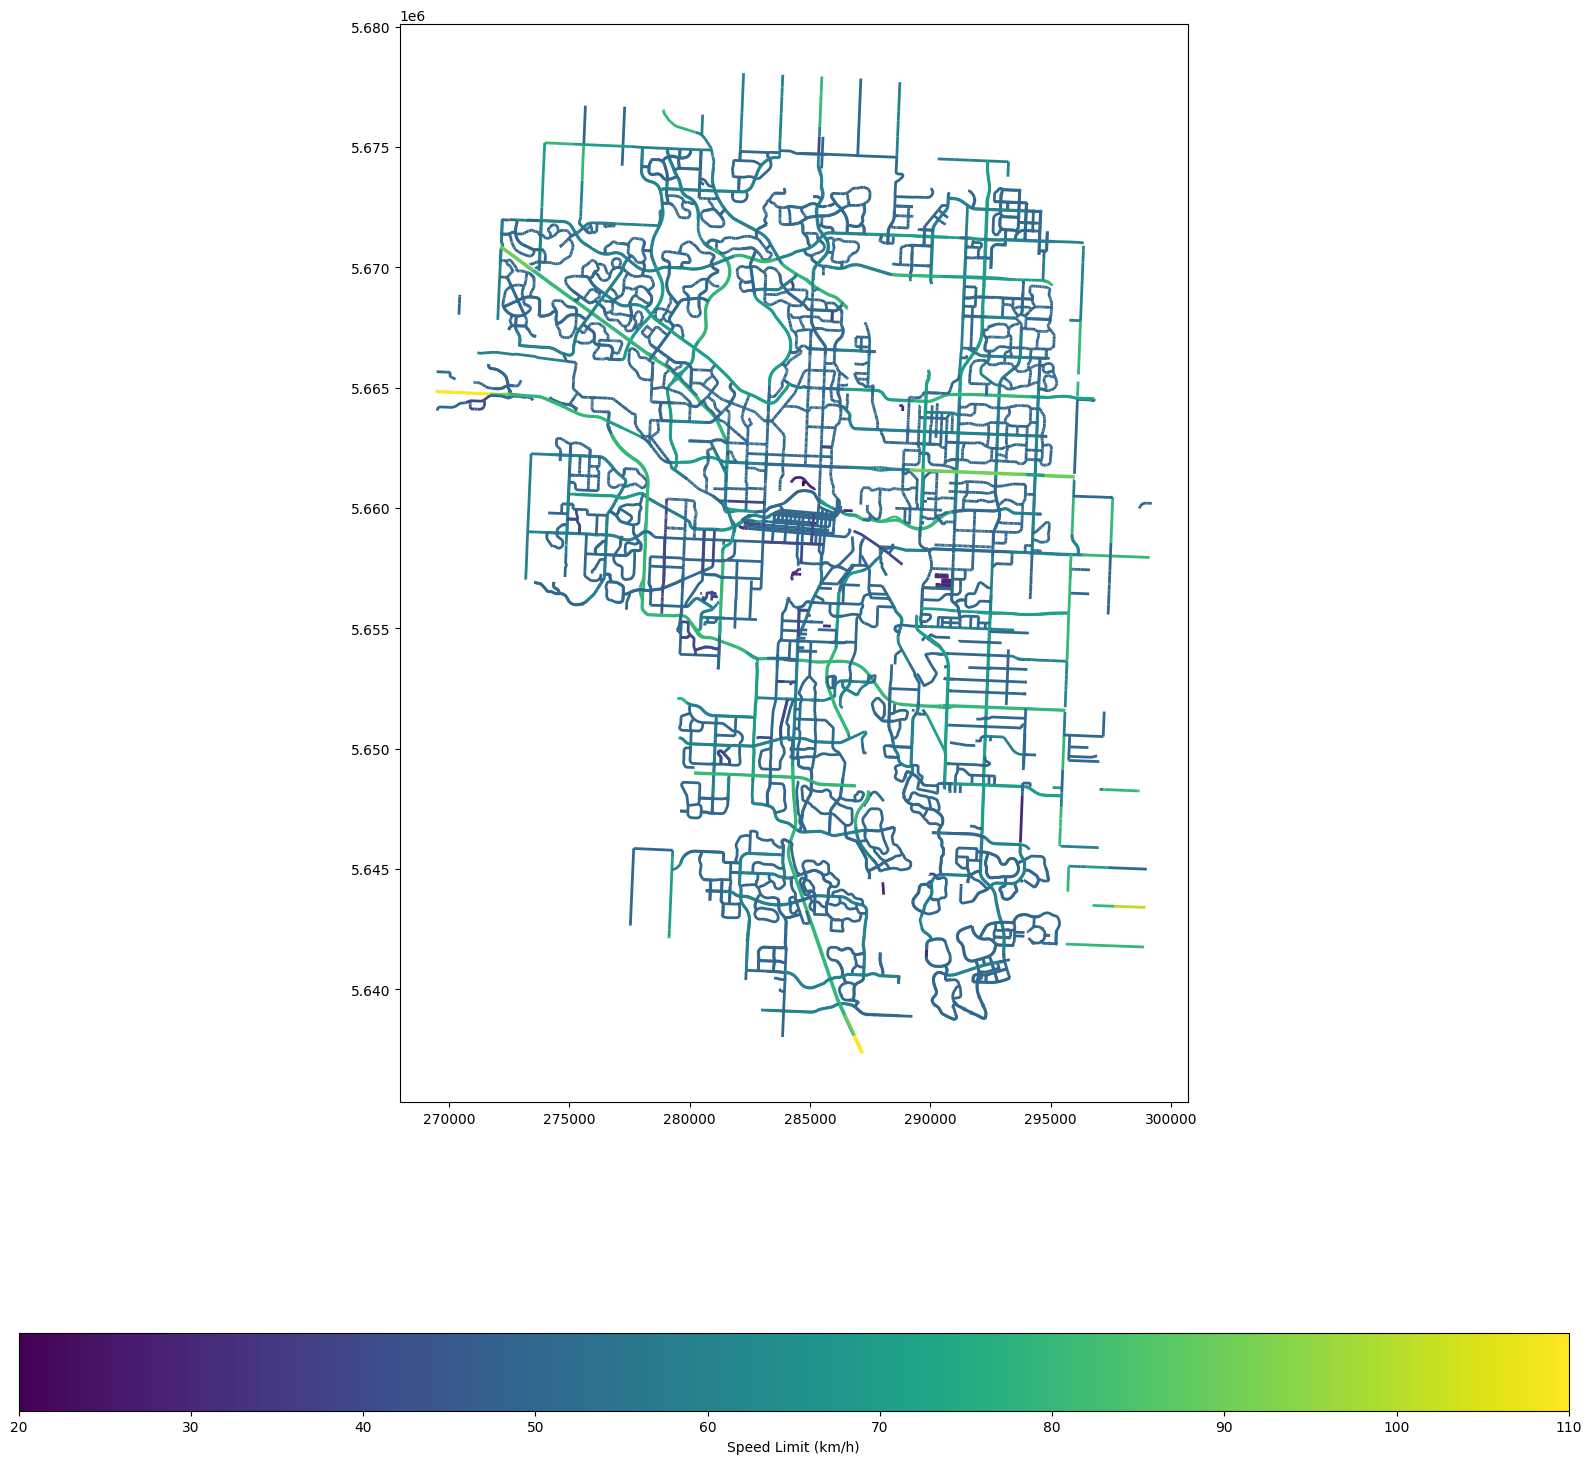

In [6]:
# Load the JSON data from the given URL
url = "Speed_Limits_20240308.csv"
data_speed_limits = pd.read_csv(url)

data_speed_limits['geometry'] = data_speed_limits['multiline'].apply(wkt.loads)
data_speed_limits = gpd.GeoDataFrame(data_speed_limits, geometry='geometry')
data_speed_limits.set_crs(epsg=4326, inplace=True)
data_speed_limits = data_speed_limits.to_crs(epsg=32612)

# Display the first few rows of the DataFrame to verify
display(data_speed_limits.head())
display(data_speed_limits.info())

fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
data_speed_limits.plot(
    ax=ax,
    column='SPEED',  # Specify the column based on which to vary colors
    linewidth=2,
    legend=True,  # Add a legend
    cmap='viridis',  # Specify a colormap
    legend_kwds={
        'label': "Speed Limit (km/h)",
        'orientation': "horizontal"
    }
)

plt.show()

In [7]:
# Sampling 1/100 records randomly
sampled_df = data_speed_limits.sample(n=int(len(data_speed_limits)/100), random_state=1)  # Fixed random state for reproducibility

# Save the sampled data to a CSV file
sampled_file_path = 'Speed_Limits_small.csv'
sampled_df.to_csv(sampled_file_path, index=False)

# Return the path to the saved CSV file for download
sampled_file_path

'Speed_Limits_small.csv'

### All Speed limit

geometry  SPEED_LIMIT
0  MULTILINESTRING ((287625.389 5646480.682, 2875...         40.0
1  MULTILINESTRING ((287589.401 5646481.723, 2875...         40.0
2  MULTILINESTRING ((287619.171 5646387.709, 2875...         40.0
3  MULTILINESTRING ((287582.876 5646390.366, 2875...         40.0
4  MULTILINESTRING ((287625.083 5646266.020, 2876...         40.0

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 76523 entries, 0 to 76522
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     76523 non-null  geometry
 1   SPEED_LIMIT  57917 non-null  float64 
dtypes: float64(1), geometry(1)
memory usage: 1.2 MB


None

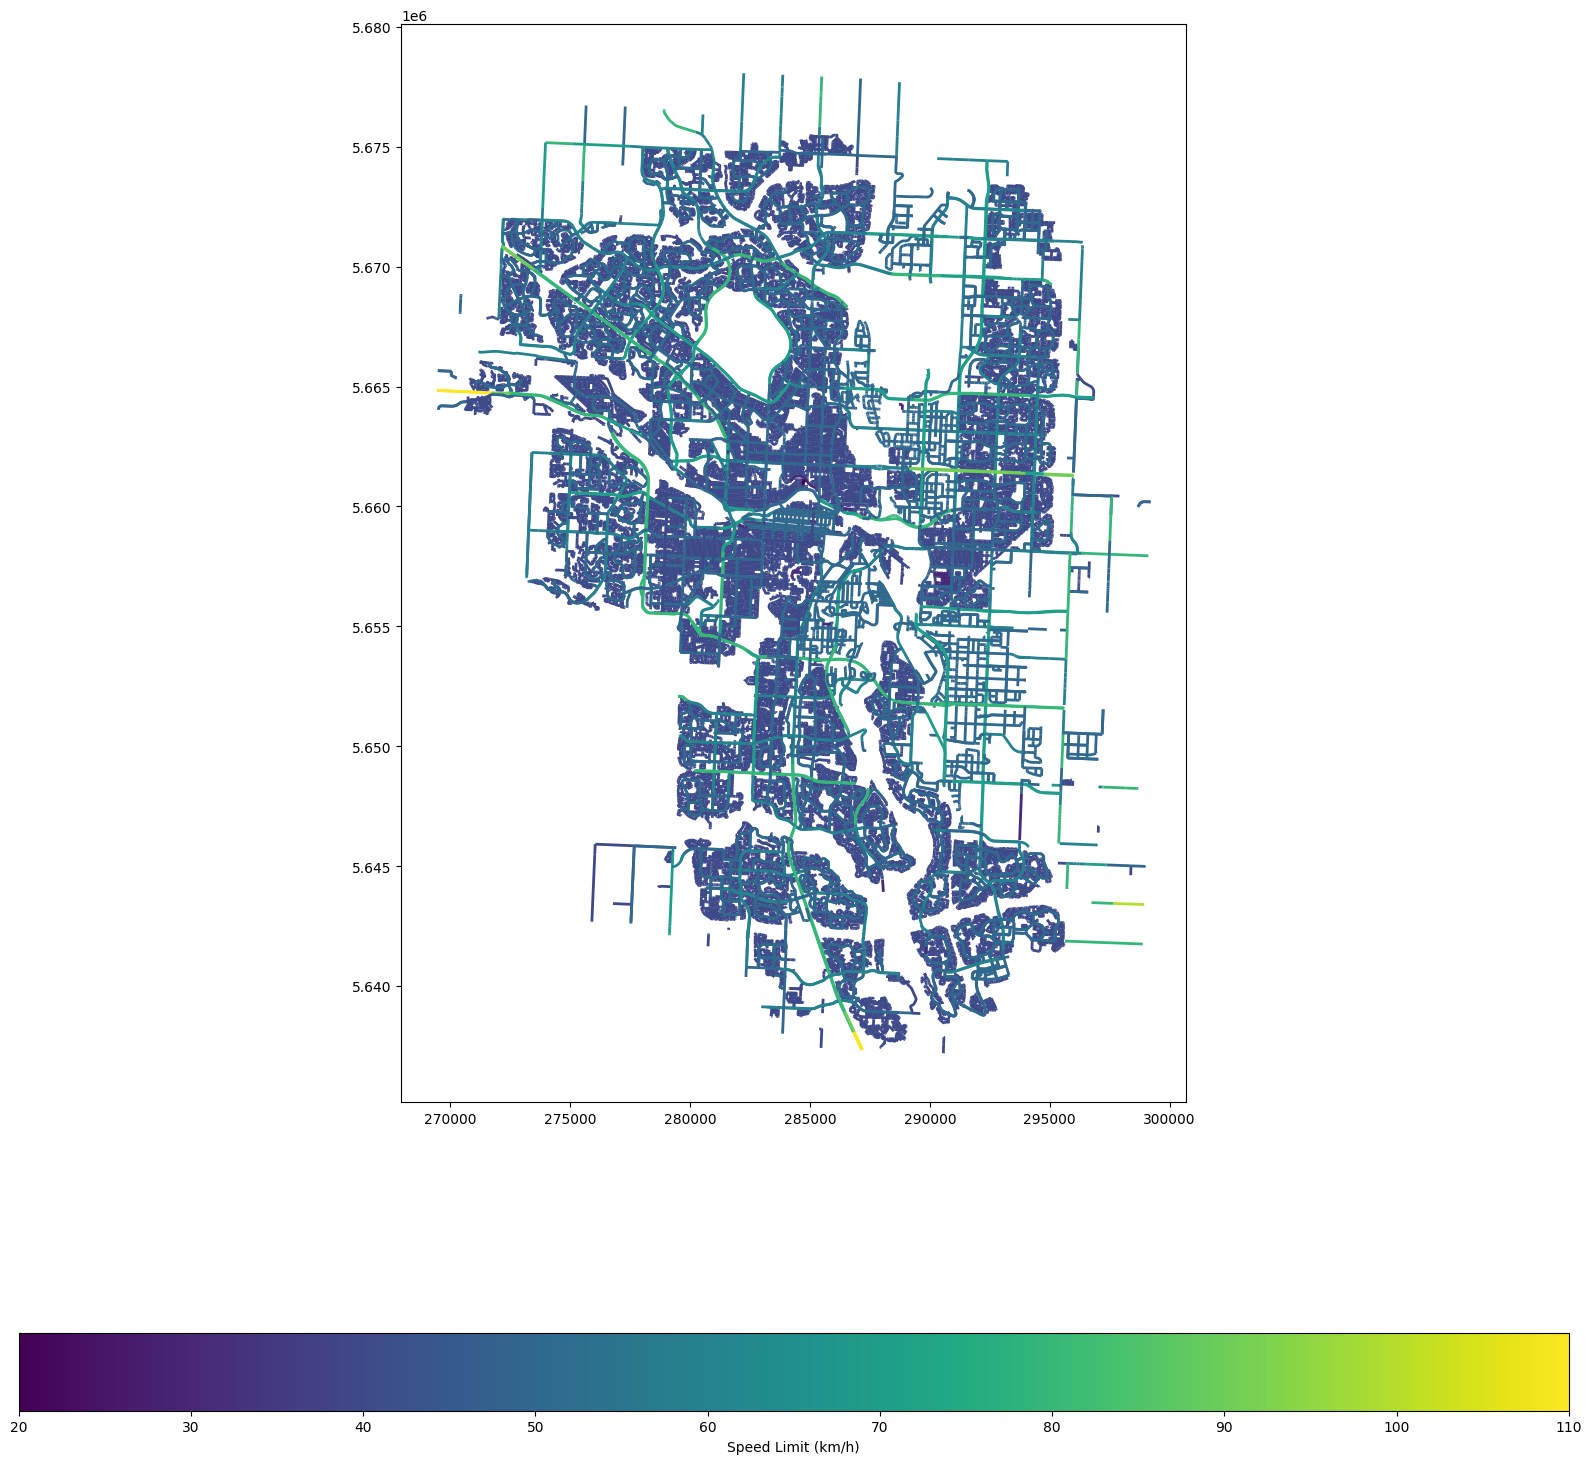

In [8]:
# For data_neighbourhood_speed_limits, the column is already named 'SPEED_LIMIT'
# For data_speed_limits, rename 'SPEED' to 'SPEED_LIMIT'
data_speed_limits.rename(columns={'SPEED': 'SPEED_LIMIT'}, inplace=True)

# If there are additional columns in either DataFrame you wish to retain, rename or drop them accordingly
# Concatenate the two GeoDataFrames
all_speed_limits = pd.concat([data_neighbourhood_speed_limits[['geometry', 'SPEED_LIMIT']],
                              data_speed_limits[['geometry', 'SPEED_LIMIT']]],
                             ignore_index=True)

# Verify the concatenated DataFrame
display(all_speed_limits.head())
display(all_speed_limits.info())
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the combined speed limits
all_speed_limits.plot(
    ax=ax,
    column='SPEED_LIMIT',  # Color by speed limit
    linewidth=2,
    legend=True,
    cmap='viridis',  # Choose a colormap that suits your needs
    legend_kwds={
        'label': "Speed Limit (km/h)",
        'orientation': "horizontal"
    }
)

plt.show()


In [9]:
# Sampling 1/100 records randomly
sampled_df = all_speed_limits.sample(n=int(len(all_speed_limits)/100), random_state=1)  # Fixed random state for reproducibility

# Save the sampled data to a CSV file
sampled_file_path = 'all_speed_limits.csv'
sampled_df.to_csv(sampled_file_path, index=False)

# Return the path to the saved CSV file for download
sampled_file_path

'all_speed_limits.csv'

### Traffic Incidents

INCIDENT INFO  \
0   Westbound 16 Avenue at Deerfoot Trail NE    
1                  11 Avenue and 4 Street SW    
2             68 Street and Memorial Drive E    
3       Eastbound 16 Avenue and 36 Street NE    
4              Barlow Trail and 61 Avenue SE    

                                         DESCRIPTION                START_DT  \
0  Stalled vehicle.  Partially blocking the right...  2022/06/21 07:31:40 AM   
1          Traffic incident. Blocking multiple lanes  2022/06/21 04:02:11 AM   
2                                  Traffic incident.  2022/06/20 11:53:08 PM   
3       Traffic incident. Blocking the left shoulder  2022/06/20 04:43:21 PM   
4                                  Traffic incident.  2022/06/20 04:42:12 PM   

              MODIFIED_DT QUADRANT   Longitude   Latitude  Count  \
0  2022/06/21 07:33:16 AM       NE -114.026687  51.067485      1   
1  2022/06/21 04:12:38 AM       SW -114.071481  51.042624      1   
2  2022/06/20 11:55:42 PM       NE -113.935553  51.052474      1   
3  2022/06/20 05:17:05 PM       NE -113.989219  51.067086      1   
4  2022/06/20 05:28:21 PM       SE -113.985727  50.998727      1   

                                                  id  \
0  2022-06-21T07:31:4051.067485129276236-114.0266...   
1  2022-06-21T04:02:1151.04262449261462-114.07148...   
2  2022-06-20T23:53:0851.0524735056658-113.935553...   
3  2022-06-20T16:43:2151.06708565896752-113.98921...   
4  2022-06-20T16:42:1250.99872748477766-113.98572...   

                                            Point  \
0  POINT (-114.02668672232672 51.067485129276236)   
1   POINT (-114.07148057660925 51.04262449261462)   
2      POINT (-113.935553325751 51.0524735056658)   
3   POINT (-113.98921905311566 51.06708565896752)   
4   POINT (-113.98572655353505 50.99872748477766)   

                         geometry  
0  POINT (287947.519 5661688.224)  
1  POINT (284694.505 5659054.445)  
2  POINT (294264.652 5659760.710)  
3  POINT (290570.231 5661536.535)  
4  POINT (290506.687 5653927.027)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45861 entries, 0 to 45860
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   INCIDENT INFO  45861 non-null  object  
 1   DESCRIPTION    45859 non-null  object  
 2   START_DT       45861 non-null  object  
 3   MODIFIED_DT    31804 non-null  object  
 4   QUADRANT       31802 non-null  object  
 5   Longitude      45861 non-null  float64 
 6   Latitude       45861 non-null  float64 
 7   Count          45861 non-null  int64   
 8   id             45861 non-null  object  
 9   Point          45861 non-null  object  
 10  geometry       45861 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(7)
memory usage: 3.8+ MB


None

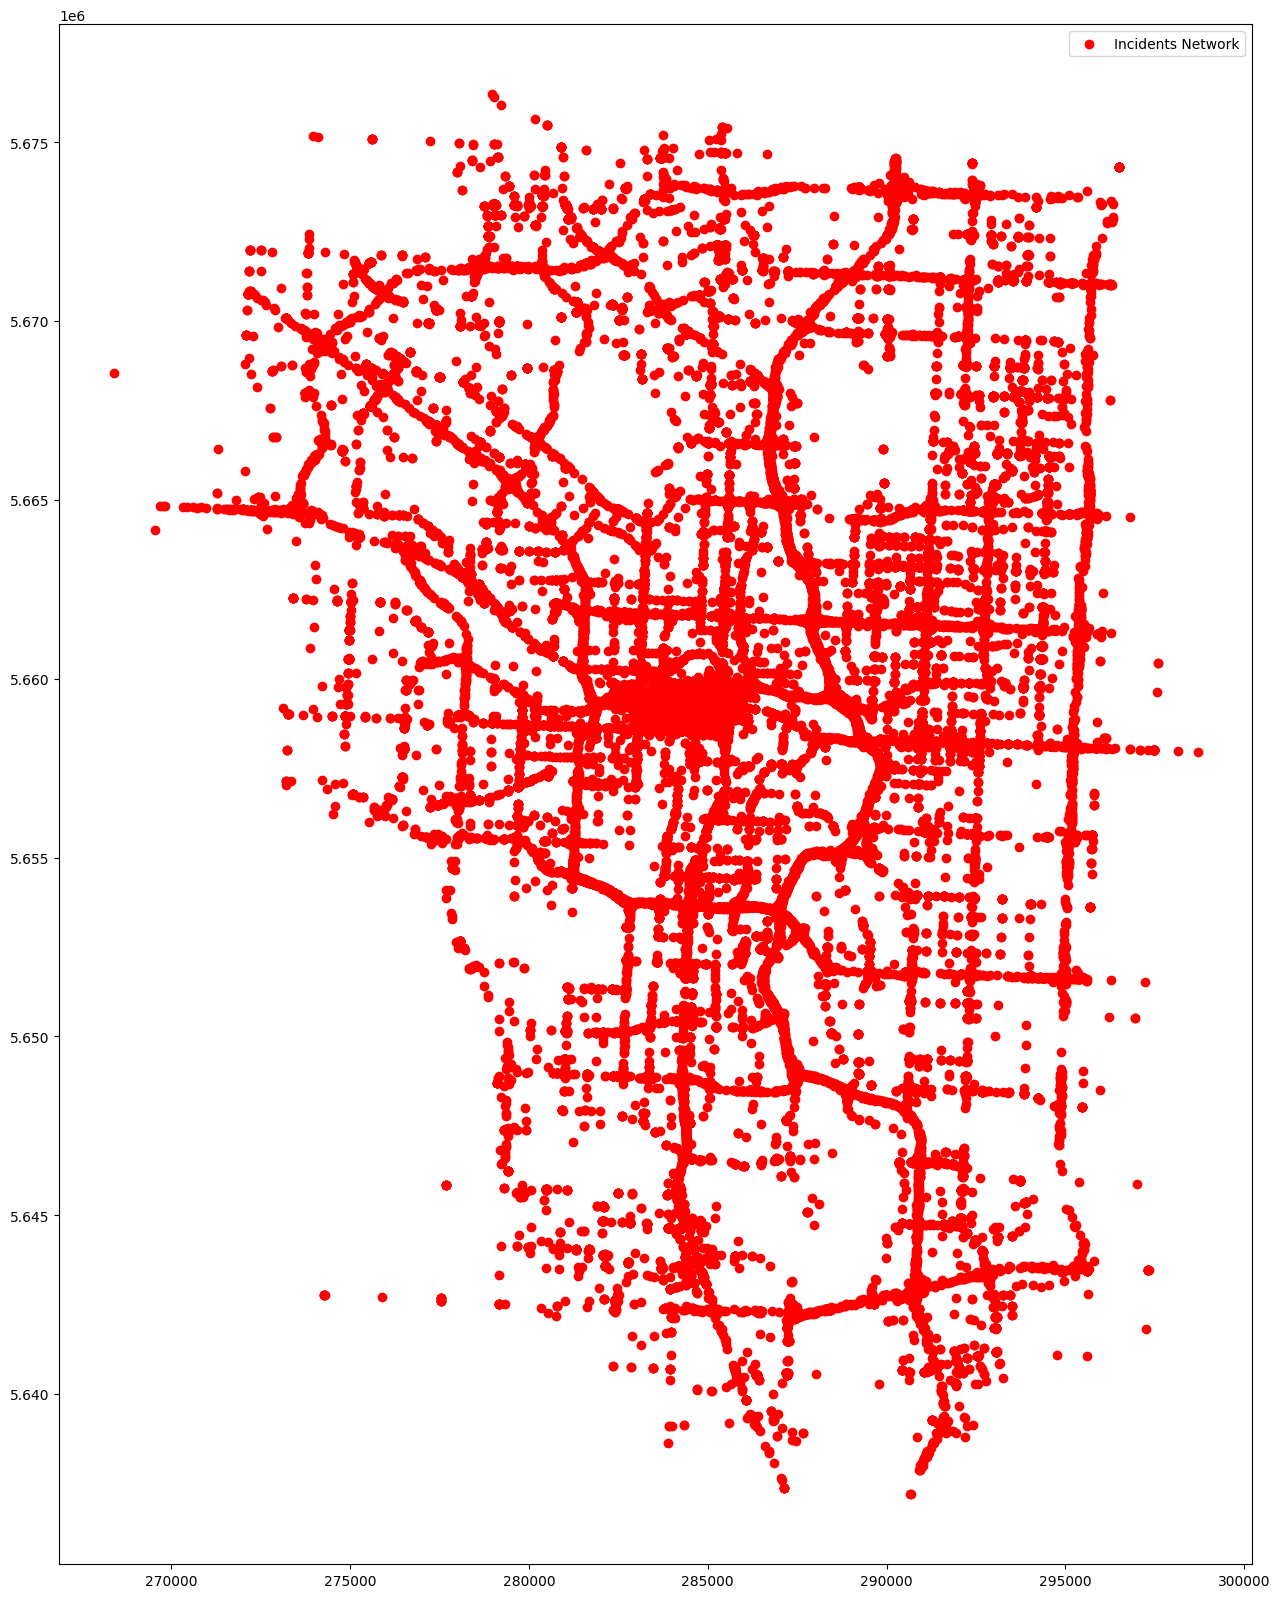

In [10]:

# Load the JSON data from the given URL
url = "Traffic_Incidents_20240306.csv"
data_incidents = pd.read_csv(url)

data_incidents['geometry'] = data_incidents['Point'].apply(wkt.loads)
data_incidents = gpd.GeoDataFrame(data_incidents, geometry='geometry')
data_incidents.set_crs(epsg=4326, inplace=True)
data_incidents = data_incidents.to_crs(epsg=32612)

# Display the first few rows of the DataFrame to verify
display(data_incidents.head())
display(data_incidents.info())

fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
data_incidents.plot(ax=ax, color='red', linewidth=1, label='Incidents Network')

plt.legend()
plt.show()

In [11]:
# # Sampling 1/100 records randomly
# sampled_df = data_incidents.sample(n=int(len(data_incidents)/100), random_state=1)  # Fixed random state for reproducibility

# # Save the sampled data to a CSV file
# sampled_file_path = 'Traffic_Incidents_small.csv'
# sampled_df.to_csv(sampled_file_path, index=False)

# # Return the path to the saved CSV file for download
# sampled_file_path

### Traffic Signal Signs

INSTDATE SIGN_CODE                  SIGN_DSCRN SIGN_SIZE   SIGN_TYPE  \
6   2017/10/26    11-250                        KRMS   600x750  Flat Sheet   
7   2020/12/02    11-250                        KRMS   600x750  Flat Sheet   
9   2021/01/18    14-320    TAC Pedestrian Crosswalk  900x1200       Other   
10  2013/09/24    14-308        Pedestrian Crosswalk   600x750  Flat Sheet   
11  2018/07/23    11-647  Turn Control - Thru + Left   900x900  Flat Sheet   

   SUPPORT_TYPE                            POINT  \
6      Pedestal  POINT (-114.1969592 51.1542101)   
7      Pedestal  POINT (-114.2109842 51.0594918)   
9           Arm  POINT (-114.0758307 51.1115973)   
10        Trunk  POINT (-114.1022882 51.0576832)   
11          Arm  POINT (-114.0317578 51.0474608)   

                          geometry  
6   POINT (276439.761 5671833.766)  
7   POINT (274999.449 5661346.785)  
9   POINT (284710.187 5666734.990)  
10  POINT (282605.945 5660819.075)  
11  POINT (287500.600 5659476.697)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4675 entries, 6 to 5215
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   INSTDATE      4675 non-null   object  
 1   SIGN_CODE     4675 non-null   object  
 2   SIGN_DSCRN    4675 non-null   object  
 3   SIGN_SIZE     4675 non-null   object  
 4   SIGN_TYPE     4675 non-null   object  
 5   SUPPORT_TYPE  4675 non-null   object  
 6   POINT         4675 non-null   object  
 7   geometry      4675 non-null   geometry
dtypes: geometry(1), object(7)
memory usage: 328.7+ KB


None

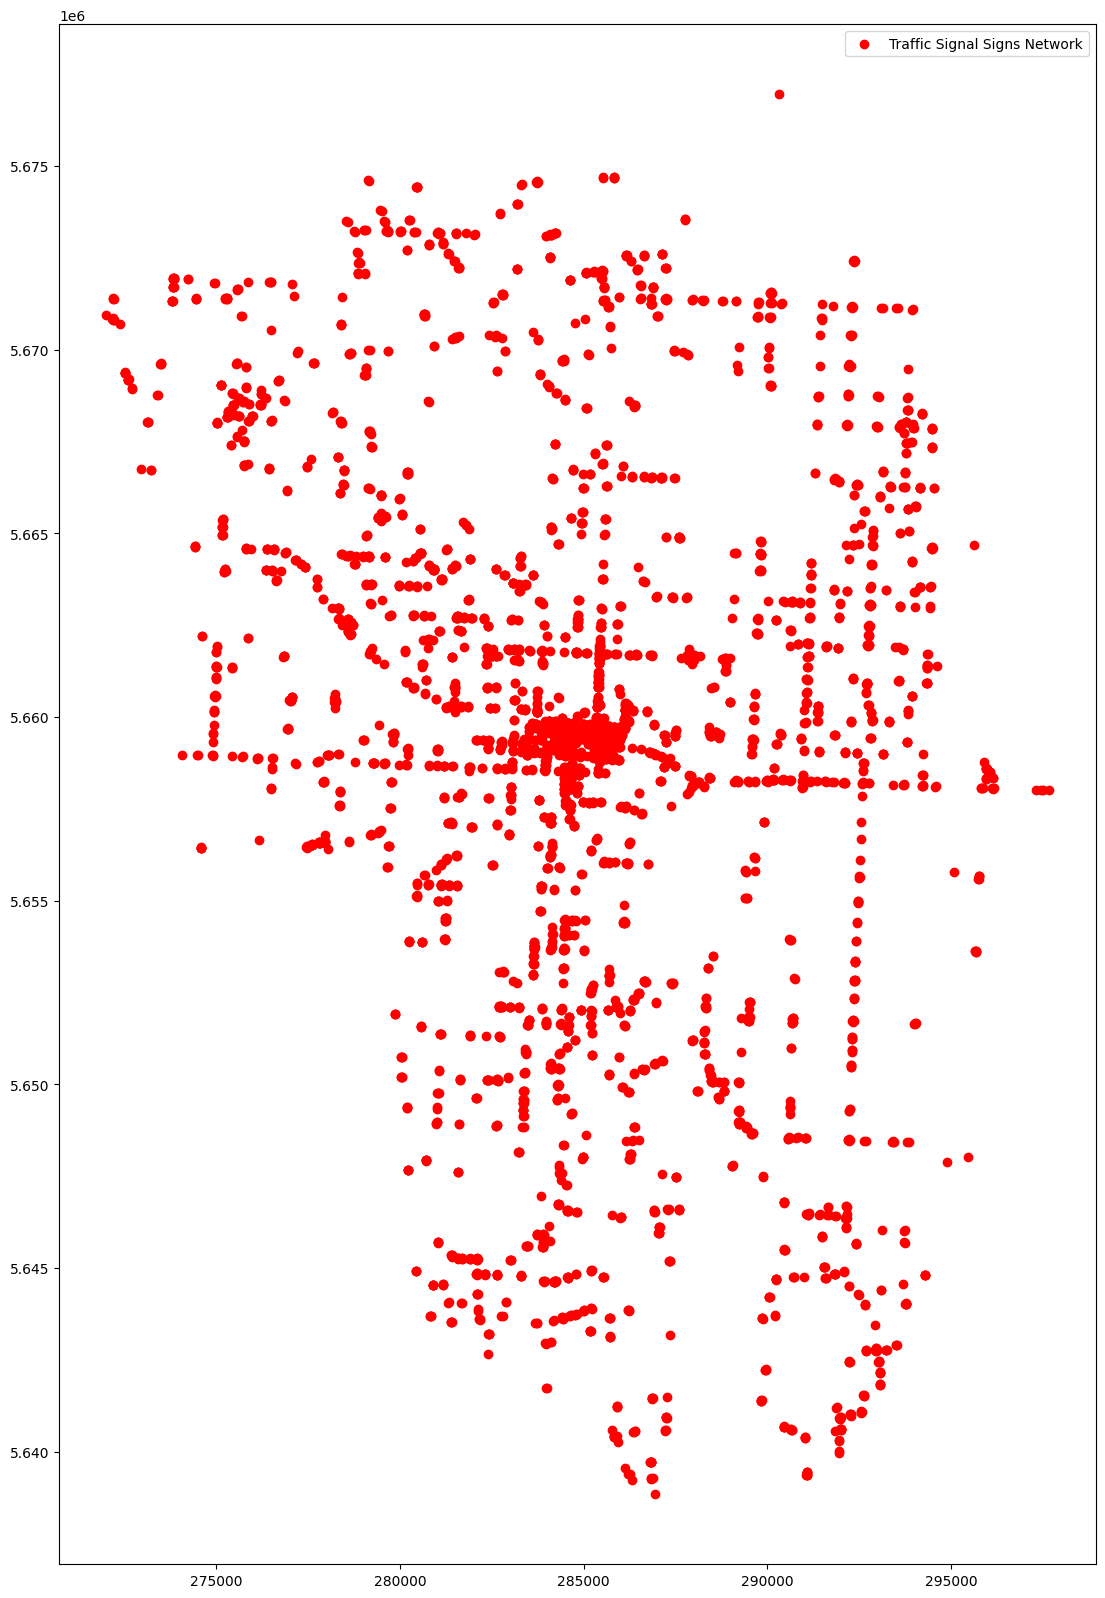

In [12]:
url = "Traffic_Signal_Signs_20240309.csv"
temp = pd.read_csv(url)

data_sign=temp[['INSTDATE','SIGN_CODE','SIGN_DSCRN','SIGN_SIZE','SIGN_TYPE','SUPPORT_TYPE','POINT']]
data_sign=data_sign.dropna()
data_sign['geometry'] = data_sign['POINT'].apply(wkt.loads)
data_sign = gpd.GeoDataFrame(data_sign, geometry='geometry')
data_sign.set_crs(epsg=4326, inplace=True)
data_sign = data_sign.to_crs(epsg=32612)

display(data_sign.head())
display(data_sign.info())

fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
data_sign.plot(ax=ax, color='red', linewidth=1, label='Traffic Signal Signs Network')

plt.legend()
plt.show()

In [13]:
# # Sampling 1/100 records randomly
# sampled_df = data_sign.sample(n=int(len(data_sign)/100), random_state=1)  # Fixed random state for reproducibility

# # Save the sampled data to a CSV file
# sampled_file_path = 'Traffic_Signal_Signs_small.csv'
# sampled_df.to_csv(sampled_file_path, index=False)

# # Return the path to the saved CSV file for download
# sampled_file_path

### Crosswalk

CROSSWALK_TYPE  CROSSWALK_COMP  \
0            RSM  PARKING STALLS   
1            RSM       STOP LINE   
2            RSM       STOP LINE   
3  MULTIWAY STOP       STOP LINE   
4     SIGNALIZED      RIGHT TURN   

                                           POINT  \
0  POINT (-114.08130604284372 51.06727641297475)   
1   POINT (-114.14111928809288 51.1831099606199)   
2  POINT (-114.13499902937271 51.18319156789337)   
3  POINT (-114.08128908263517 50.98601632264809)   
4  POINT (-114.14117612481596 51.06009319728565)   

                         geometry  
0  POINT (284120.635 5661823.806)  
1  POINT (280481.098 5674878.256)  
2  POINT (280909.112 5674869.061)  
3  POINT (283743.760 5652790.011)  
4  POINT (279892.864 5661202.565)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4030 entries, 0 to 4048
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CROSSWALK_TYPE  4030 non-null   object  
 1   CROSSWALK_COMP  4030 non-null   object  
 2   POINT           4030 non-null   object  
 3   geometry        4030 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 157.4+ KB


None

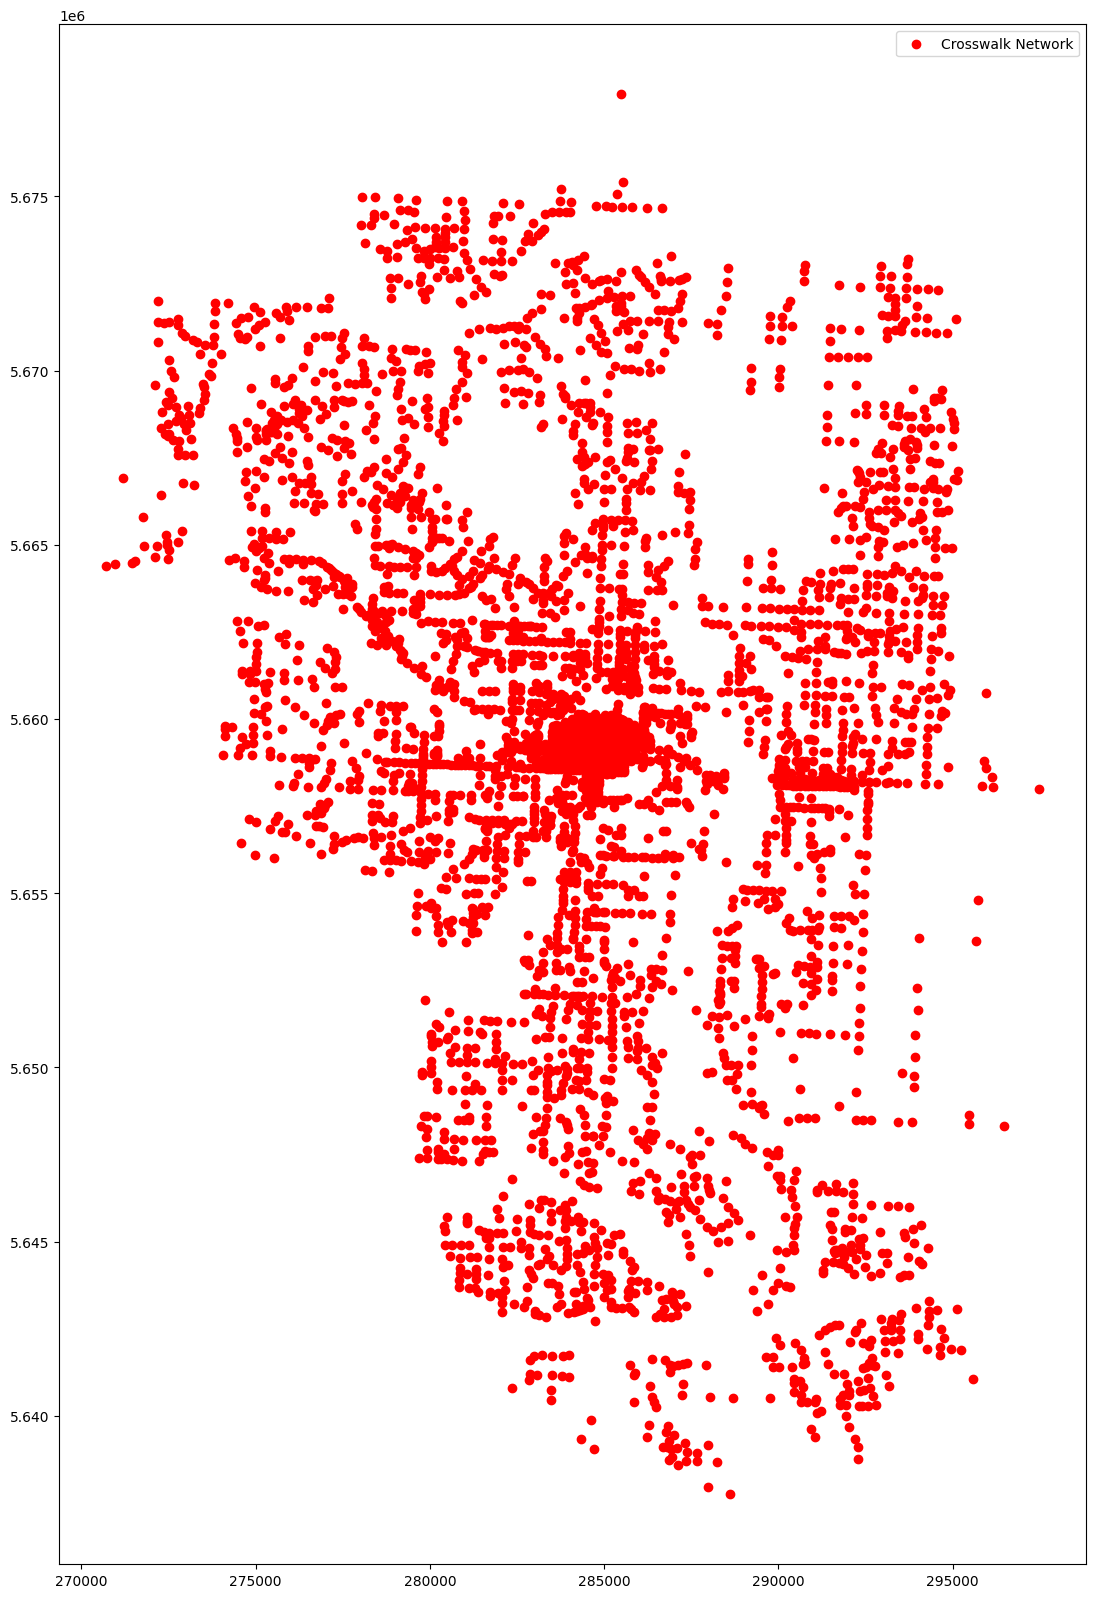

In [14]:
url = "Crosswalks_20240309.csv"
temp = pd.read_csv(url)

data_crosswalk=temp[['CROSSWALK_TYPE','CROSSWALK_COMP','POINT']]
data_crosswalk = data_crosswalk.dropna(subset=['CROSSWALK_TYPE', 'CROSSWALK_COMP'])

data_crosswalk['geometry'] = data_crosswalk['POINT'].apply(wkt.loads)
data_crosswalk = gpd.GeoDataFrame(data_crosswalk, geometry='geometry')
data_crosswalk.set_crs(epsg=4326, inplace=True)
data_crosswalk = data_crosswalk.to_crs(epsg=32612)

display(data_crosswalk.head())
display(data_crosswalk.info())

fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
data_crosswalk.plot(ax=ax, color='red', linewidth=1, label='Crosswalk Network')

plt.legend()
plt.show()

In [15]:
# # Sampling 1/100 records randomly
# sampled_df = data_crosswalk.sample(n=int(len(data_crosswalk)/100), random_state=1)  # Fixed random state for reproducibility

# # Save the sampled data to a CSV file
# sampled_file_path = 'Crosswalks_small.csv'
# sampled_df.to_csv(sampled_file_path, index=False)

# # Return the path to the saved CSV file for download
# sampled_file_path

### Traffic Volumes in 2022 - may not useful

In [16]:

# # Load the JSON data from the given URL
# url = "Traffic_Volumes_for_2022_20240306.csv"
# data_traffic_volumes = pd.read_csv(url)

# data_traffic_volumes['geometry'] = data_traffic_volumes['multilinestring'].apply(wkt.loads)
# data_traffic_volumes = gpd.GeoDataFrame(data_traffic_volumes, geometry='geometry')
# data_traffic_volumes.set_crs(epsg=4326, inplace=True)
# data_traffic_volumes = data_traffic_volumes.to_crs(epsg=32612)

# # Display the first few rows of the DataFrame to verify
# display(data_traffic_volumes.head())
# display(data_traffic_volumes.info())

# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# data_traffic_volumes.plot(
#     ax=ax,
#     column='Volume',  # Specify the column based on which to vary colors
#     linewidth=2,
#     legend=True,  # Add a legend
#     cmap='viridis',  # Specify a colormap
#     legend_kwds={
#         'label': "Volume",
#         'orientation': "horizontal"
#     }
# )

# plt.show()

### Major Road Network - may be useful later

In [17]:

# # Load the JSON data from the given URL
# url = "Major_Road_Network_20240306.csv"
# data_road_network = pd.read_csv(url)

# data_road_network['geometry'] = data_road_network['the_geom'].apply(wkt.loads)
# data_road_network = gpd.GeoDataFrame(data_road_network, geometry='geometry')
# data_road_network.set_crs(epsg=4326, inplace=True)
# data_road_network = data_road_network.to_crs(epsg=32612)

# # Display the first few rows of the DataFrame to verify
# display(data_road_network.head())
# display(data_road_network.info())


# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# data_road_network.plot(
#     ax=ax,
#     linewidth=2
# )

# plt.show()

In [18]:
# # Create a figure and axis for the plot
# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# data_road_network.plot(ax=ax, linewidth=1, color='gray', label='Road Network')

# # Plot traffic incidents
# data_incidents.plot(ax=ax, color='red', markersize=10, label='Traffic Incidents', alpha=0.5)

# # Add legend
# # Note: For custom legends, you might need to manually define legend entries because geopandas plots don't automatically combine legend info well.
# legend_elements = [Line2D([0], [0], color='gray', lw=1, label='Road Network'),
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Traffic Incidents')]
# ax.legend(handles=legend_elements, loc='upper left')

# plt.show()

In [19]:
# # Create a figure and axis for the plot
# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# all_speed_limits.plot(ax=ax, linewidth=1, color='gray', label='Speed Limits Network')

# # Plot traffic incidents
# data_incidents.plot(ax=ax, color='red', markersize=10, label='Traffic Incidents', alpha=0.5)

# # Add legend
# # Note: For custom legends, you might need to manually define legend entries because geopandas plots don't automatically combine legend info well.
# legend_elements = [Line2D([0], [0], color='gray', lw=1, label='Speed Limits Network'),
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Traffic Incidents')]
# ax.legend(handles=legend_elements, loc='upper left')

# plt.show()

### divide the road to piece

geometry  SPEED_LIMIT
0       POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0
1       POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0
2       POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0
3       POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0
4       POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0
...                                                   ...          ...
225775  POLYGON ((294449.080 5661355.582, 294448.599 5...         70.0
225776  POLYGON ((294349.193 5661360.331, 294348.712 5...         70.0
225777  POLYGON ((294249.306 5661365.081, 294248.825 5...         70.0
225778  POLYGON ((294149.419 5661369.830, 294148.937 5...         70.0
225779  POLYGON ((294096.484 5661372.347, 294096.003 5...         70.0

[225780 rows x 2 columns]

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 225780 entries, 0 to 225779
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     225780 non-null  geometry
 1   SPEED_LIMIT  171464 non-null  float64 
dtypes: float64(1), geometry(1)
memory usage: 3.4 MB


None

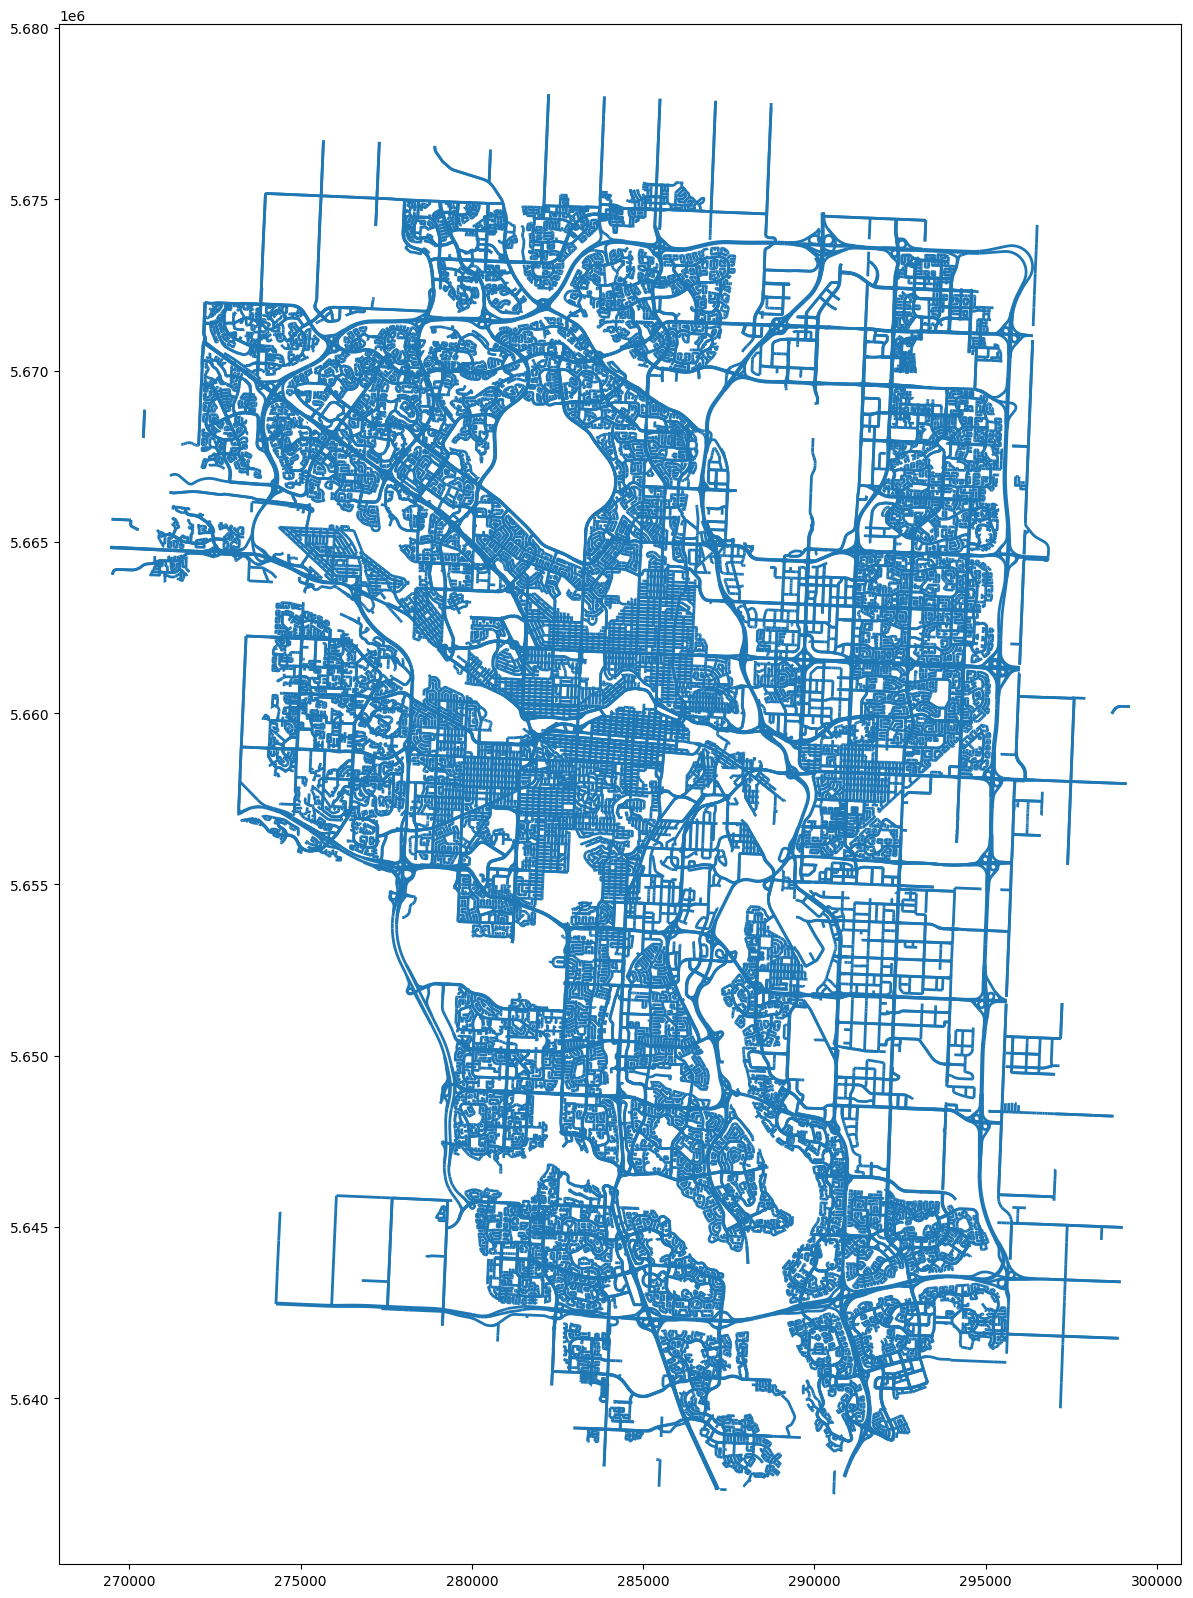

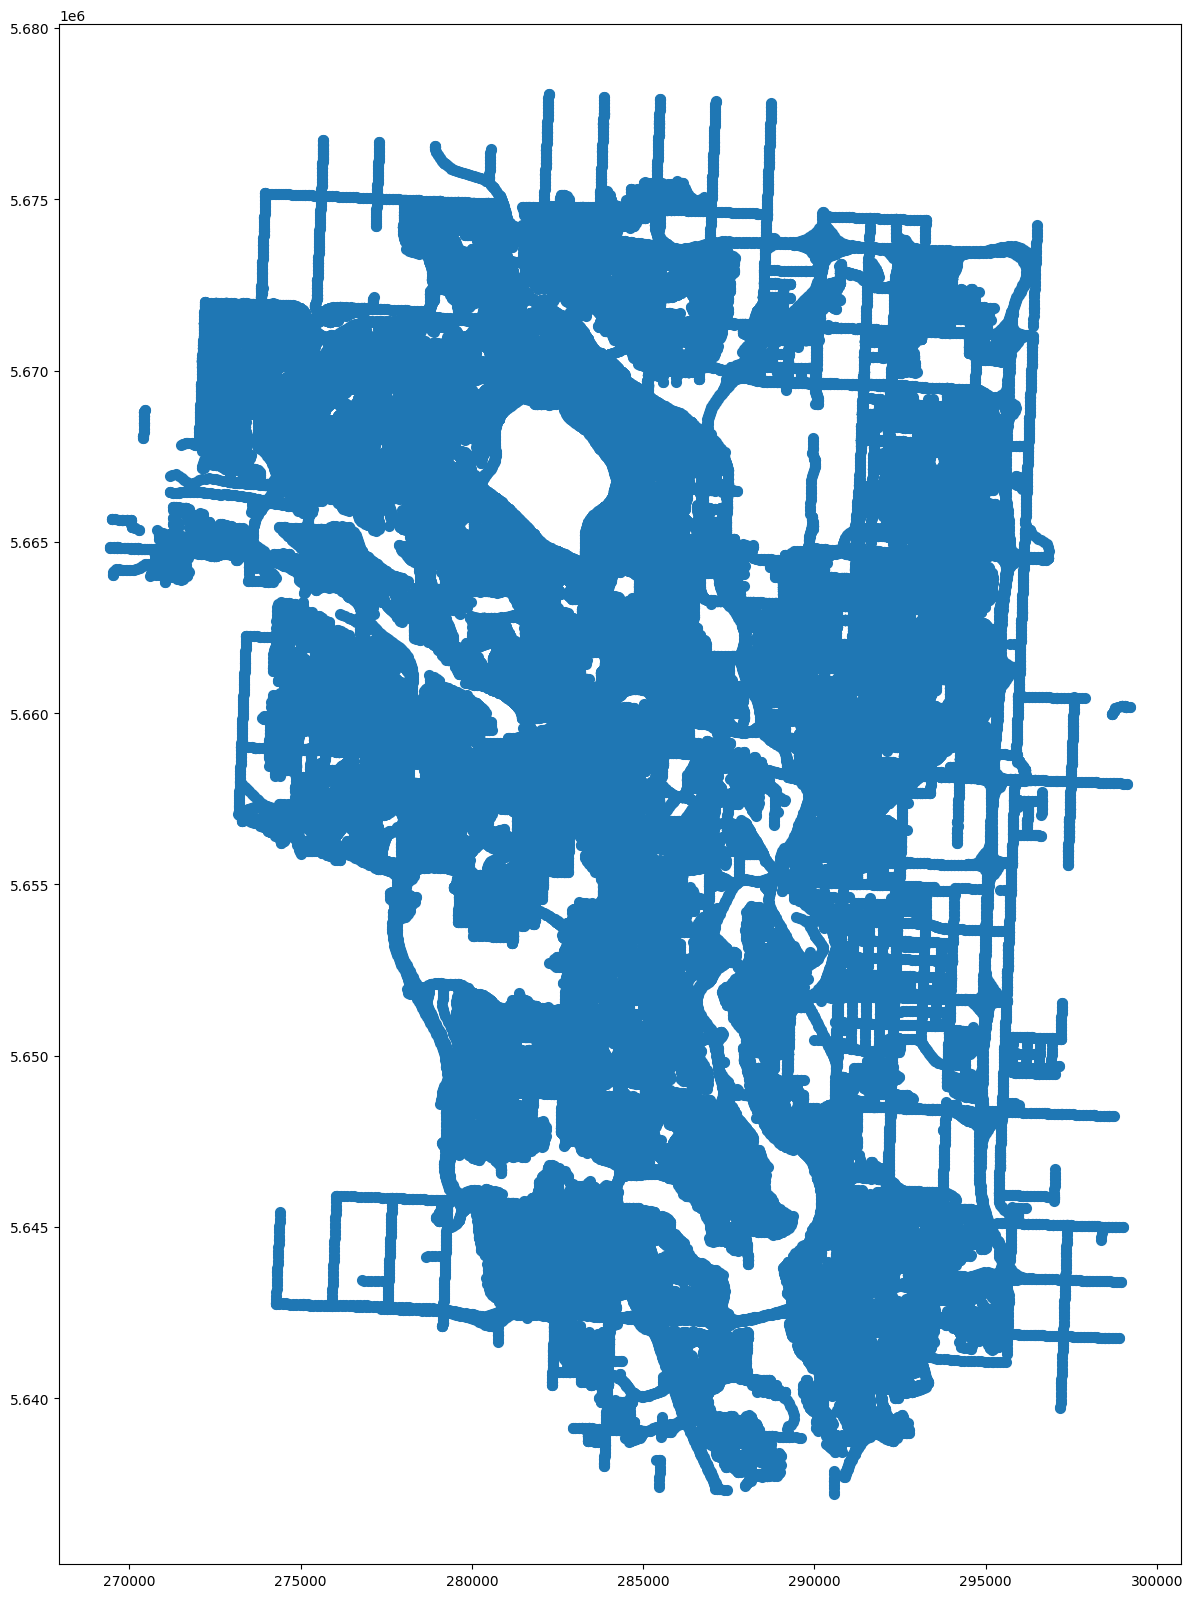

In [20]:
base_dataframe = all_speed_limits.copy()
base_dataframe.set_crs(epsg=32612, inplace=True)

# Function to generate points along a line at specified intervals
def generate_points_along_line(line, interval, speed_limit):
    length = line.length
    distances = np.arange(0, length + interval, interval)  # Ensure covering the entire line
    points = [line.interpolate(distance) for distance in distances]
    speed_limits = [speed_limit for _ in distances]
    return points, speed_limits

# List to collect points
points_list = []
speed_limits_list = []

# Iterate over each geometry in the GeoDataFrame
for index, row in base_dataframe.iterrows():
    geom = row.geometry
    speed_limit = row.SPEED_LIMIT
    if isinstance(geom, LineString):
        points, speed_limits = generate_points_along_line(geom, area_interval, speed_limit)
        points_list.extend(points)
        speed_limits_list.extend(speed_limits)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:  # Correctly iterate over LineStrings in a MultiLineString
            points, speed_limits = generate_points_along_line(line, area_interval, speed_limit)
            points_list.extend(points)
            speed_limits_list.extend(speed_limits)

# Convert the list of points to a GeoDataFrame
points_gdf = gpd.GeoDataFrame({'geometry': points_list, 'SPEED_LIMIT': speed_limits_list})
points_gdf.set_crs(epsg=32612, inplace=True)

points_gdf_buffered = points_gdf.copy()
points_gdf_buffered['geometry'] = points_gdf_buffered.buffer(area_interval)
points_gdf_buffered.set_crs(epsg=32612, inplace=True)

# Display the first few rows to verify
display(points_gdf_buffered)
display(points_gdf_buffered.info())



fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
base_dataframe.plot(
    ax=ax,
    linewidth=2
)

plt.show()

fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
points_gdf.plot(
    ax=ax,
    linewidth=2
)

plt.show()


## Merge the data to one dataframe

### Function for merging Dataframe


In [21]:
def mergeDFwithLineDF(base_df, line_df, column_name_to_match):
    # Ensure both GeoDataFrames are in the same CRS
    base_df_temp = base_df.copy()
    base_df_temp.set_crs(epsg=32612, inplace=True)
    display(base_df_temp.head())

    line_df_temp = line_df.copy()
    line_df_temp.set_crs(epsg=32612, inplace=True)
    display(line_df_temp.head())

    # Step 1: Perform the spatial join as before
    joined = gpd.sjoin(base_df_temp, line_df_temp[['geometry', column_name_to_match]], how='left', predicate = 'intersects')
    # joined = gpd.sjoin_nearest(points_gdf_to_merge, data_speed_limits_to_merge[['geometry', column_name_to_match]], how='left', max_distance=area_interval)
    display(joined.head())

    # Step 2: Calculate the mean SPEED_LIMIT for each point in points_with_camera_speed
    # Assuming points_with_camera_speed has a unique index we can group by
    joined = joined.groupby(joined.index)[column_name_to_match].mean()

    # Step 3: Merge this mean SPEED_LIMIT back onto points_with_camera_speed
    # Ensure points_with_camera_speed has a proper index; reset it if needed
    new_col_name = column_name_to_match
    joined.reset_index(drop=True, inplace=True)

    base_df_temp = base_df_temp.merge(joined, how='left', left_index=True, right_index=True)

    # Now points_with_camera_speed should have the same number of rows as originally, with mean SPEED_LIMIT added
    display(base_df_temp.head())
    display(base_df_temp.info())
    return base_df_temp


In [22]:
def mergeDFwithPointDF(base_df, point_df, column_name_to_count):
    # Ensure both GeoDataFrames are in the same CRS
    base_df_temp = base_df.copy()
    base_df_temp.set_crs(epsg=32612, inplace=True)
    display(base_df_temp.head())

    point_df_temp = point_df.copy()
    point_df_temp.set_crs(epsg=32612, inplace=True)
    display(point_df_temp.head())

    
    # Step 1: Perform the spatial join as before
    joined = gpd.sjoin(base_df_temp, point_df_temp[['geometry']], how='inner', predicate = 'intersects')
    # display(joined)

    joined['temp_count'] = 1  # You might not need this if column_name_to_count exists and is meaningful
    aggregation = joined.groupby(joined.index).size()

    base_df_temp[column_name_to_count] = 0
    # Merge the aggregated values back to the base_df
    base_df_temp.loc[aggregation.index, column_name_to_count] = aggregation.values


    # Now points_with_camera_speed should have the same number of rows as originally, with mean SPEED_LIMIT added
    display(base_df_temp.head())
    display(base_df_temp.info())
    return base_df_temp



In [23]:

# Creating a sample base dataframe (LineString geometries simulating roads)
base_data = {
    'road_id': [1, 2, 3, 4],
    'geometry': [LineString([(0, 0), (1, 1)]), LineString([(2, 2), (3, 3)]), LineString([(4, 4), (5, 5)]), LineString([(40, 40), (50, 50)])]
}
base_df = gpd.GeoDataFrame(base_data, geometry='geometry')
base_df.set_crs(epsg=32612, inplace=True)

# Creating a sample point dataframe (Point geometries simulating incidents or features)
point_data = {
    'point_id': [1, 2, 3, 4, 5],
    'geometry': [Point(0.5, 0.5), Point(2.5, 2.5), Point(3, 3), Point(10, 10), Point(4.5, 4.5)]
}
point_df = gpd.GeoDataFrame(point_data, geometry='geometry')
point_df.set_crs(epsg=32612, inplace=True)

# Test the function
merged_df = mergeDFwithPointDF(base_df, point_df, 'Incidents_Count')

# Displaying the merged GeoDataFrame
display(merged_df)

road_id                                   geometry
0        1      LINESTRING (0.000 0.000, 1.000 1.000)
1        2      LINESTRING (2.000 2.000, 3.000 3.000)
2        3      LINESTRING (4.000 4.000, 5.000 5.000)
3        4  LINESTRING (40.000 40.000, 50.000 50.000)

point_id               geometry
0         1    POINT (0.500 0.500)
1         2    POINT (2.500 2.500)
2         3    POINT (3.000 3.000)
3         4  POINT (10.000 10.000)
4         5    POINT (4.500 4.500)

road_id                                   geometry  Incidents_Count
0        1      LINESTRING (0.000 0.000, 1.000 1.000)                1
1        2      LINESTRING (2.000 2.000, 3.000 3.000)                2
2        3      LINESTRING (4.000 4.000, 5.000 5.000)                1
3        4  LINESTRING (40.000 40.000, 50.000 50.000)                0

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   road_id          4 non-null      int64   
 1   geometry         4 non-null      geometry
 2   Incidents_Count  4 non-null      int64   
dtypes: geometry(1), int64(2)
memory usage: 228.0 bytes


None

road_id                                   geometry  Incidents_Count
0        1      LINESTRING (0.000 0.000, 1.000 1.000)                1
1        2      LINESTRING (2.000 2.000, 3.000 3.000)                2
2        3      LINESTRING (4.000 4.000, 5.000 5.000)                1
3        4  LINESTRING (40.000 40.000, 50.000 50.000)                0

### Map the point with speed limit

In [24]:
# # Ensure both GeoDataFrames are in the same CRS
# df_with_speed = mergeDFwithLineDF(points_gdf_buffered, all_speed_limits, 'SPEED_LIMIT')

# display(df_with_speed.info())
# # Count the number of NA values in each column
# na_counts = df_with_speed.isna().sum()

# # Display the counts
# print(f"na_counts {na_counts}")

# na_rows = df_with_speed[df_with_speed['SPEED_LIMIT'].isna()]

# # Display these rows
# print(f"na_rows {na_rows}")

# # Identifying matched (where mean_SPEED_LIMIT is not NaN) and unmatched points
# matched_points = df_with_speed.dropna(subset=['SPEED_LIMIT'])
# unmatched_points = df_with_speed[df_with_speed['SPEED_LIMIT'].isna()]

# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# points_gdf_buffered.plot(ax=ax, color='gray', linewidth=1, label='Road Network')

# # Plot matched points
# matched_points.plot(ax=ax, color='green', markersize=5, label='Matched Points')

# # Plot unmatched points
# unmatched_points.plot(ax=ax, color='red', markersize=5, label='Unmatched Points')

# plt.legend()
# plt.show()


# df_with_speed = df_with_speed.dropna(subset=['SPEED_LIMIT'])
# # Display these rows
# print(df_with_speed.info())


### Merge the points with number of incidents

geometry  SPEED_LIMIT
0  POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0
1  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0
2  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0
3  POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0
4  POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0

INCIDENT INFO  \
0   Westbound 16 Avenue at Deerfoot Trail NE    
1                  11 Avenue and 4 Street SW    
2             68 Street and Memorial Drive E    
3       Eastbound 16 Avenue and 36 Street NE    
4              Barlow Trail and 61 Avenue SE    

                                         DESCRIPTION                START_DT  \
0  Stalled vehicle.  Partially blocking the right...  2022/06/21 07:31:40 AM   
1          Traffic incident. Blocking multiple lanes  2022/06/21 04:02:11 AM   
2                                  Traffic incident.  2022/06/20 11:53:08 PM   
3       Traffic incident. Blocking the left shoulder  2022/06/20 04:43:21 PM   
4                                  Traffic incident.  2022/06/20 04:42:12 PM   

              MODIFIED_DT QUADRANT   Longitude   Latitude  Count  \
0  2022/06/21 07:33:16 AM       NE -114.026687  51.067485      1   
1  2022/06/21 04:12:38 AM       SW -114.071481  51.042624      1   
2  2022/06/20 11:55:42 PM       NE -113.935553  51.052474      1   
3  2022/06/20 05:17:05 PM       NE -113.989219  51.067086      1   
4  2022/06/20 05:28:21 PM       SE -113.985727  50.998727      1   

                                                  id  \
0  2022-06-21T07:31:4051.067485129276236-114.0266...   
1  2022-06-21T04:02:1151.04262449261462-114.07148...   
2  2022-06-20T23:53:0851.0524735056658-113.935553...   
3  2022-06-20T16:43:2151.06708565896752-113.98921...   
4  2022-06-20T16:42:1250.99872748477766-113.98572...   

                                            Point  \
0  POINT (-114.02668672232672 51.067485129276236)   
1   POINT (-114.07148057660925 51.04262449261462)   
2      POINT (-113.935553325751 51.0524735056658)   
3   POINT (-113.98921905311566 51.06708565896752)   
4   POINT (-113.98572655353505 50.99872748477766)   

                         geometry  
0  POINT (287947.519 5661688.224)  
1  POINT (284694.505 5659054.445)  
2  POINT (294264.652 5659760.710)  
3  POINT (290570.231 5661536.535)  
4  POINT (290506.687 5653927.027)

geometry  SPEED_LIMIT  Indcidents
0  POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0           1
1  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1
2  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1
3  POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0           1
4  POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0           0

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 225780 entries, 0 to 225779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     225780 non-null  geometry
 1   SPEED_LIMIT  171464 non-null  float64 
 2   Indcidents   225780 non-null  int64   
dtypes: float64(1), geometry(1), int64(1)
memory usage: 5.2 MB


None

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 225780 entries, 0 to 225779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     225780 non-null  geometry
 1   SPEED_LIMIT  171464 non-null  float64 
 2   Indcidents   225780 non-null  int64   
dtypes: float64(1), geometry(1), int64(1)
memory usage: 5.2 MB


None

na_counts geometry           0
SPEED_LIMIT    54316
Indcidents         0
dtype: int64
na_rows Empty GeoDataFrame
Columns: [geometry, SPEED_LIMIT, Indcidents]
Index: []


C:\Users\lidou\AppData\Local\Temp\ipykernel_22028\3219616374.py:29: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  unmatched_points.plot(ax=ax, color='red', markersize=5, label='Unmatched Points')
C:\Users\lidou\AppData\Local\Temp\ipykernel_22028\3219616374.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


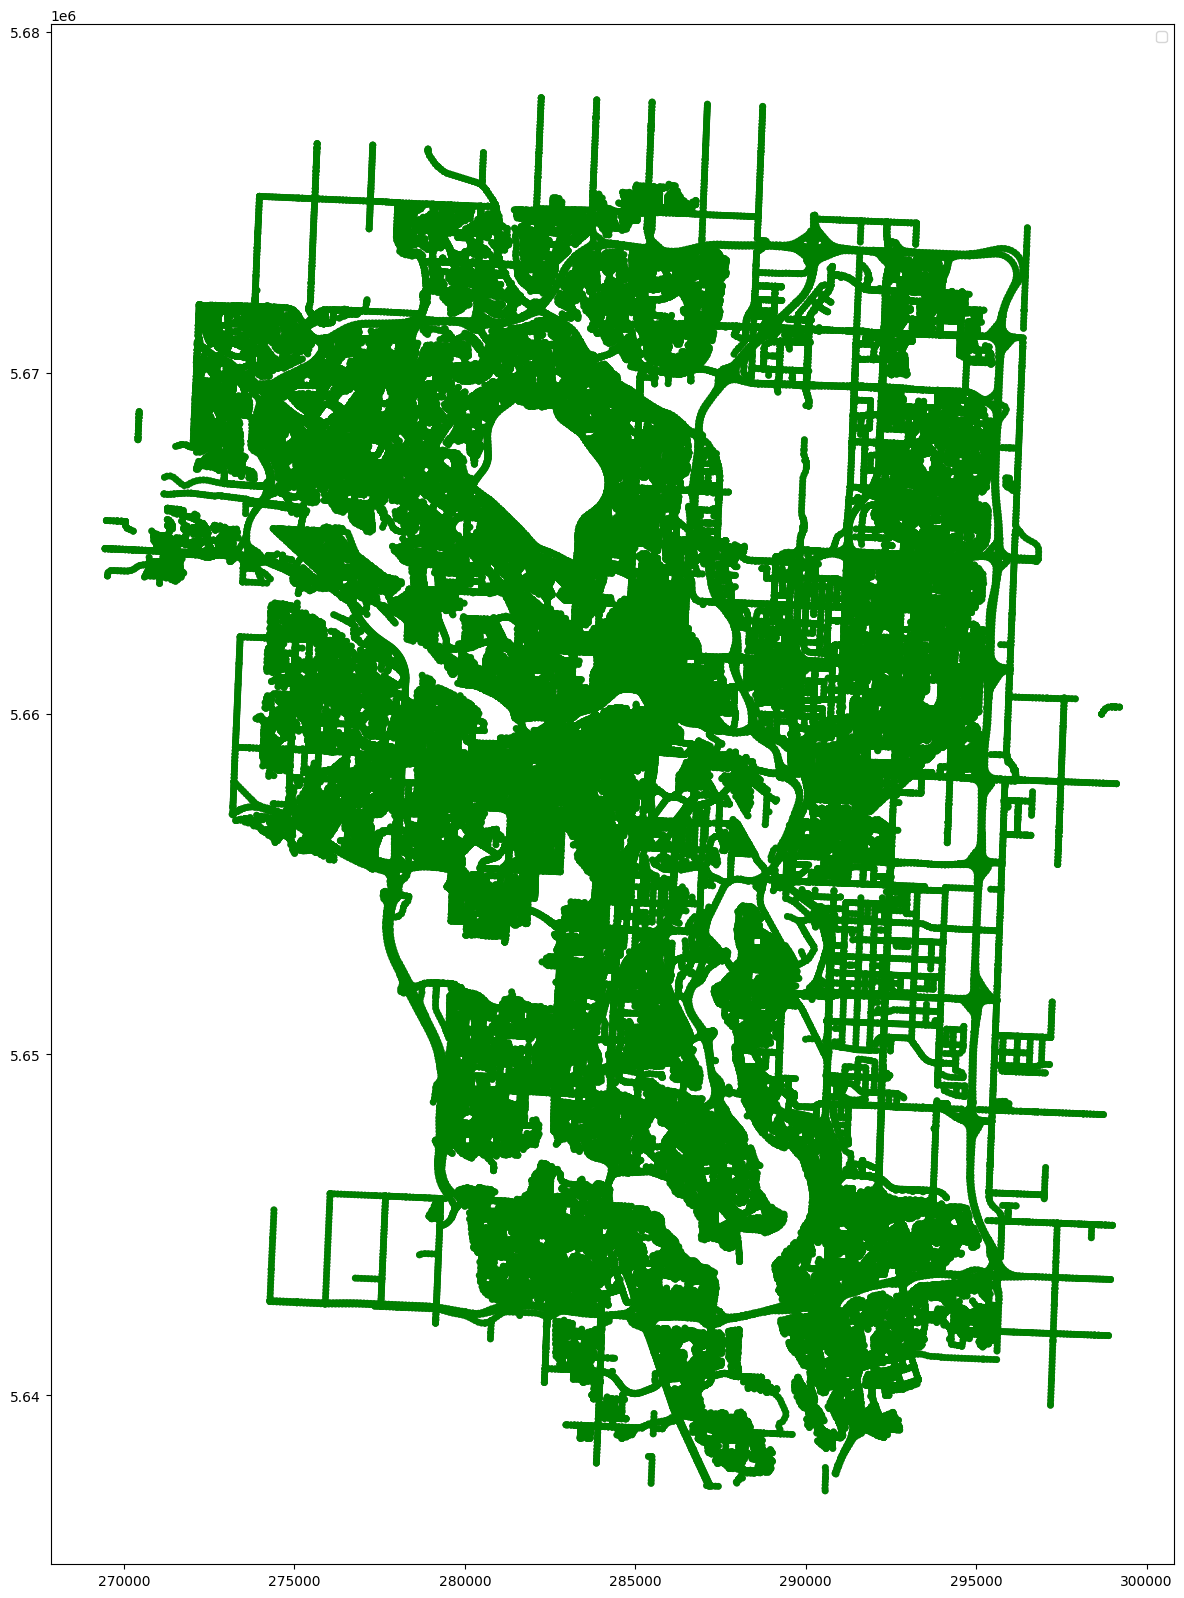

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 171464 entries, 0 to 225779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     171464 non-null  geometry
 1   SPEED_LIMIT  171464 non-null  float64 
 2   Indcidents   171464 non-null  int64   
dtypes: float64(1), geometry(1), int64(1)
memory usage: 5.2 MB
None


In [25]:

# Ensure both GeoDataFrames are in the same CRS
df_with_speed_incidents = mergeDFwithPointDF(points_gdf_buffered, data_incidents, 'Indcidents')

display(df_with_speed_incidents.info())
# Count the number of NA values in each column
na_counts = df_with_speed_incidents.isna().sum()

# Display the counts
print(f"na_counts {na_counts}")

na_rows = df_with_speed_incidents[df_with_speed_incidents['Indcidents'].isna()]

# Display these rows
print(f"na_rows {na_rows}")

# Identifying matched (where mean_SPEED_LIMIT is not NaN) and unmatched points
matched_points = df_with_speed_incidents.dropna(subset=['Indcidents'])
unmatched_points = df_with_speed_incidents[df_with_speed_incidents['Indcidents'].isna()]

fig, ax = plt.subplots(figsize=(20, 20))

# Plot road network
points_gdf_buffered.plot(ax=ax, color='gray', linewidth=1, label='Road Network')

# Plot matched points
matched_points.plot(ax=ax, color='green', markersize=5, label='Matched Points')

# Plot unmatched points
unmatched_points.plot(ax=ax, color='red', markersize=5, label='Unmatched Points')

plt.legend()
plt.show()

df_with_speed_incidents = df_with_speed_incidents.dropna(subset=['SPEED_LIMIT', 'Indcidents'])
print(df_with_speed_incidents.info())


### Merge the points with number of Traffic Signal Signs

In [26]:

# # Ensure both GeoDataFrames are in the same CRS
# df_with_speed_incidents_sign = mergeDFwithPointDF(df_with_speed_incidents, data_sign, 'Sign')

# display(df_with_speed_incidents_sign.info())
# # Count the number of NA values in each column
# na_counts = df_with_speed_incidents_sign.isna().sum()

# # Display the counts
# print(f"na_counts {na_counts}")

# na_rows = df_with_speed_incidents_sign[df_with_speed_incidents_sign['Sign'].isna()]

# # Display these rows
# print(f"na_rows {na_rows}")

# # Identifying matched (where mean_SPEED_LIMIT is not NaN) and unmatched points
# matched_points = df_with_speed_incidents_sign.dropna(subset=['Sign'])
# unmatched_points = df_with_speed_incidents_sign[df_with_speed_incidents_sign['Sign'].isna()]

# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# points_gdf_buffered.plot(ax=ax, color='gray', linewidth=1, label='Road Network')

# # Plot matched points
# matched_points.plot(ax=ax, color='green', markersize=5, label='Matched Points')

# # Plot unmatched points
# unmatched_points.plot(ax=ax, color='red', markersize=5, label='Unmatched Points')

# plt.legend()
# plt.show()

# df_with_speed_incidents_sign = df_with_speed_incidents_sign.dropna(subset=['SPEED_LIMIT', 'Indcidents', 'Sign'])
# print(df_with_speed_incidents_sign.info())


In [27]:
import re

def extract_size(sign_size):
    # Handle various delimiters and remove non-numeric characters
    sign_size = re.sub(r'[^\d.x]', '', sign_size.lower())  # Remove everything except numbers, 'x', and '.'
    
    # Extract numbers (width and height)
    numbers = re.findall(r'\d+', sign_size)
    
    # Calculate area if two dimensions are found
    if len(numbers) == 2:
        width, height = map(int, numbers)
        return width * height  # Return the calculated area
    elif len(numbers) == 1:
        # If only one dimension is provided, assume a square sign
        dimension = int(numbers[0])
        return dimension * dimension
    return None  # Return None if the proper dimensions couldn't be extracted

# Apply the function to the 'SIGN_SIZE' column to create a new 'Area' column
data_sign['Area'] = data_sign['SIGN_SIZE'].apply(extract_size)

# Drop rows where area could not be calculated
data_sign = data_sign.dropna(subset=['Area'])

# Define size thresholds based on quantiles
small_threshold = data_sign['Area'].quantile(0.33)
large_threshold = data_sign['Area'].quantile(0.67)

# Function to categorize sizes
def categorize_size(area):
    if area < small_threshold:
        return 'Small'
    elif area < large_threshold:
        return 'Medium'
    else:
        return 'Large'

# Apply the categorization function
data_sign['Size_Category'] = data_sign['Area'].apply(categorize_size)


# Display updated DataFrame information
display(data_sign.head())
display(data_sign.info())


C:\Users\lidou\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


INSTDATE SIGN_CODE                  SIGN_DSCRN SIGN_SIZE   SIGN_TYPE  \
6   2017/10/26    11-250                        KRMS   600x750  Flat Sheet   
7   2020/12/02    11-250                        KRMS   600x750  Flat Sheet   
9   2021/01/18    14-320    TAC Pedestrian Crosswalk  900x1200       Other   
10  2013/09/24    14-308        Pedestrian Crosswalk   600x750  Flat Sheet   
11  2018/07/23    11-647  Turn Control - Thru + Left   900x900  Flat Sheet   

   SUPPORT_TYPE                            POINT  \
6      Pedestal  POINT (-114.1969592 51.1542101)   
7      Pedestal  POINT (-114.2109842 51.0594918)   
9           Arm  POINT (-114.0758307 51.1115973)   
10        Trunk  POINT (-114.1022882 51.0576832)   
11          Arm  POINT (-114.0317578 51.0474608)   

                          geometry       Area Size_Category  
6   POINT (276439.761 5671833.766)   450000.0        Medium  
7   POINT (274999.449 5661346.785)   450000.0        Medium  
9   POINT (284710.187 5666734.990)  1080000.0         Large  
10  POINT (282605.945 5660819.075)   450000.0        Medium  
11  POINT (287500.600 5659476.697)   810000.0         Large

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4670 entries, 6 to 5215
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   INSTDATE       4670 non-null   object  
 1   SIGN_CODE      4670 non-null   object  
 2   SIGN_DSCRN     4670 non-null   object  
 3   SIGN_SIZE      4670 non-null   object  
 4   SIGN_TYPE      4670 non-null   object  
 5   SUPPORT_TYPE   4670 non-null   object  
 6   POINT          4670 non-null   object  
 7   geometry       4670 non-null   geometry
 8   Area           4670 non-null   float64 
 9   Size_Category  4670 non-null   object  
dtypes: float64(1), geometry(1), object(8)
memory usage: 401.3+ KB


None

In [28]:


def mergeDFwithComplexPointDF_sign(base_df, point_df, sign_type_col, sign_size_col):
    # Ensure both GeoDataFrames are in the same CRS
    base_df_temp = base_df.copy()
    base_df_temp.set_crs(epsg=32612, inplace=True)
    display(base_df_temp.head())

    point_df_temp = point_df.copy()
    point_df_temp.set_crs(epsg=32612, inplace=True)
    display(point_df_temp.head())
    
    point_df_temp[sign_type_col] = point_df_temp[sign_type_col].fillna(0).astype(str)
    point_df_temp[sign_size_col] = point_df_temp[sign_size_col].fillna(0).astype(str)
    
    # Perform the spatial join
    joined = gpd.sjoin(base_df_temp, point_df_temp, how='left', predicate='intersects')

    # Initialize columns in base_df for sign types and sizes counts
    unique_sign_types = point_df_temp[sign_type_col].unique().astype(str)
    unique_sign_sizes = point_df_temp[sign_size_col].unique().astype(str)
    
    
    for sign_type in unique_sign_types:
        type_col_name = f"{sign_type_col}_{sign_type.replace('nan', 'unknown').replace(' ', '_')}"
        base_df_temp[type_col_name] = 0
    for sign_size in unique_sign_sizes:
        size_col_name = f"{sign_size_col}_{sign_size.replace('nan', 'unknown').replace(' ', '_')}"
        base_df_temp[size_col_name] = 0
    
    # Count occurrences for each sign type and size
    for index, group in joined.groupby(joined.index):
        for sign_type in group[sign_type_col].unique():
            type_col_name = f"{sign_type_col}_{str(sign_type).replace('nan', 'unknown').replace(' ', '_')}"
            base_df_temp.loc[index, type_col_name] = len(group[group[sign_type_col] == sign_type])
        for sign_size in group[sign_size_col].unique():
            size_col_name = f"{sign_size_col}_{str(sign_size).replace('nan', 'unknown').replace(' ', '_')}"
            base_df_temp.loc[index, size_col_name] = len(group[group[sign_size_col] == sign_size])
    
    return base_df_temp


# Call the function
df_with_speed_incidents_sign_complex = mergeDFwithComplexPointDF_sign(
    df_with_speed_incidents, data_sign, 'SIGN_TYPE', 'Size_Category'
)

df_with_speed_incidents_sign_complex = df_with_speed_incidents_sign_complex.drop(['SIGN_TYPE_unknown', 'Size_Category_unknown'], axis=1)

# Display the results
display(df_with_speed_incidents_sign_complex.head())
display(df_with_speed_incidents_sign_complex.info())




geometry  SPEED_LIMIT  Indcidents
0  POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0           1
1  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1
2  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1
3  POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0           1
4  POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0           0

INSTDATE SIGN_CODE                  SIGN_DSCRN SIGN_SIZE   SIGN_TYPE  \
6   2017/10/26    11-250                        KRMS   600x750  Flat Sheet   
7   2020/12/02    11-250                        KRMS   600x750  Flat Sheet   
9   2021/01/18    14-320    TAC Pedestrian Crosswalk  900x1200       Other   
10  2013/09/24    14-308        Pedestrian Crosswalk   600x750  Flat Sheet   
11  2018/07/23    11-647  Turn Control - Thru + Left   900x900  Flat Sheet   

   SUPPORT_TYPE                            POINT  \
6      Pedestal  POINT (-114.1969592 51.1542101)   
7      Pedestal  POINT (-114.2109842 51.0594918)   
9           Arm  POINT (-114.0758307 51.1115973)   
10        Trunk  POINT (-114.1022882 51.0576832)   
11          Arm  POINT (-114.0317578 51.0474608)   

                          geometry       Area Size_Category  
6   POINT (276439.761 5671833.766)   450000.0        Medium  
7   POINT (274999.449 5661346.785)   450000.0        Medium  
9   POINT (284710.187 5666734.990)  1080000.0         Large  
10  POINT (282605.945 5660819.075)   450000.0        Medium  
11  POINT (287500.600 5659476.697)   810000.0         Large

geometry  SPEED_LIMIT  Indcidents  \
0  POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0           1   
1  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1   
2  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1   
3  POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0           1   
4  POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0           0   

   SIGN_TYPE_Flat_Sheet  SIGN_TYPE_Other  SIGN_TYPE_Varicom  SIGN_TYPE_LED  \
0                     1                0                  0              0   
1                     1                0                  0              0   
2                     1                0                  0              0   
3                     1                0                  0              0   
4                     0                0                  0              0   

   SIGN_TYPE_Internally_illuminated  Size_Category_Medium  \
0                                 0                     1   
1                                 0                     1   
2                                 0                     1   
3                                 0                     1   
4                                 0                     0   

   Size_Category_Large  Size_Category_Small  
0                    0                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    0                    0

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 171464 entries, 0 to 225779
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   geometry                          171464 non-null  geometry
 1   SPEED_LIMIT                       171464 non-null  float64 
 2   Indcidents                        171464 non-null  int64   
 3   SIGN_TYPE_Flat_Sheet              171464 non-null  int64   
 4   SIGN_TYPE_Other                   171464 non-null  int64   
 5   SIGN_TYPE_Varicom                 171464 non-null  int64   
 6   SIGN_TYPE_LED                     171464 non-null  int64   
 7   SIGN_TYPE_Internally_illuminated  171464 non-null  int64   
 8   Size_Category_Medium              171464 non-null  int64   
 9   Size_Category_Large               171464 non-null  int64   
 10  Size_Category_Small               171464 non-null  int64   
dtypes: float64(1), geometry(1), int64(9)

None

### Merge the points with number of Crosswalk

In [29]:

# # Ensure both GeoDataFrames are in the same CRS
# df_with_speed_incidents_sign_crosswalk = mergeDFwithPointDF(df_with_speed_incidents_sign, data_crosswalk, 'Crosswalk')

# display(df_with_speed_incidents_sign_crosswalk.info())
# # Count the number of NA values in each column
# na_counts = df_with_speed_incidents_sign_crosswalk.isna().sum()

# # Display the counts
# print(f"na_counts {na_counts}")

# na_rows = df_with_speed_incidents_sign_crosswalk[df_with_speed_incidents_sign_crosswalk['Crosswalk'].isna()]

# # Display these rows
# print(f"na_rows {na_rows}")

# # Identifying matched (where mean_SPEED_LIMIT is not NaN) and unmatched points
# matched_points = df_with_speed_incidents_sign_crosswalk.dropna(subset=['Crosswalk'])
# unmatched_points = df_with_speed_incidents_sign_crosswalk[df_with_speed_incidents_sign_crosswalk['Crosswalk'].isna()]

# fig, ax = plt.subplots(figsize=(20, 20))

# # Plot road network
# points_gdf_buffered.plot(ax=ax, color='gray', linewidth=1, label='Road Network')

# # Plot matched points
# matched_points.plot(ax=ax, color='green', markersize=5, label='Matched Points')

# # Plot unmatched points
# unmatched_points.plot(ax=ax, color='red', markersize=5, label='Unmatched Points')

# plt.legend()
# plt.show()

# df_with_speed_incidents_sign_crosswalk = df_with_speed_incidents_sign_crosswalk.dropna(subset=['SPEED_LIMIT', 'Indcidents', 'Sign', 'Crosswalk'])
# print(df_with_speed_incidents_sign_crosswalk.info())


In [30]:


def mergeDFwithComplexPointDF_crosswalk(base_df, point_df, crosswalk_type_col):
    # Ensure both GeoDataFrames are in the same CRS
    base_df_temp = base_df.copy()
    base_df_temp.set_crs(epsg=32612, inplace=True)
    display(base_df_temp.head())

    point_df_temp = point_df.copy()
    point_df_temp.set_crs(epsg=32612, inplace=True)
    display(point_df_temp.head())

    point_df_temp[crosswalk_type_col] = point_df_temp[crosswalk_type_col].replace('MIDBLOCK', 'MID_BLOCK')
    
    point_df_temp[crosswalk_type_col] = point_df_temp[crosswalk_type_col].fillna(0).astype(str)
    
    # Perform the spatial join
    joined = gpd.sjoin(base_df_temp, point_df_temp, how='left', predicate='intersects')

    # Initialize columns in base_df for sign types and sizes counts
    unique_sign_types = point_df_temp[crosswalk_type_col].unique().astype(str)
    
    
    for sign_type in unique_sign_types:
        type_col_name = f"{crosswalk_type_col}_{sign_type.replace('nan', 'unknown').replace(' ', '_')}"
        base_df_temp[type_col_name] = 0
    
    # Count occurrences for each sign type and size
    for index, group in joined.groupby(joined.index):
        for sign_type in group[crosswalk_type_col].unique():
            type_col_name = f"{crosswalk_type_col}_{str(sign_type).replace('nan', 'unknown').replace(' ', '_')}"
            base_df_temp.loc[index, type_col_name] = len(group[group[crosswalk_type_col] == sign_type])
    
    return base_df_temp


# Call the function
df_with_speed_incidents_sign_crosswalk_complex = mergeDFwithComplexPointDF_crosswalk(
    df_with_speed_incidents_sign_complex, data_crosswalk, 'CROSSWALK_TYPE'
)

df_with_speed_incidents_sign_crosswalk_complex = df_with_speed_incidents_sign_crosswalk_complex.drop(['CROSSWALK_TYPE_unknown'], axis=1)

# Display the results
display(df_with_speed_incidents_sign_crosswalk_complex.head())
display(df_with_speed_incidents_sign_crosswalk_complex.info())




geometry  SPEED_LIMIT  Indcidents  \
0  POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0           1   
1  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1   
2  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1   
3  POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0           1   
4  POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0           0   

   SIGN_TYPE_Flat_Sheet  SIGN_TYPE_Other  SIGN_TYPE_Varicom  SIGN_TYPE_LED  \
0                     1                0                  0              0   
1                     1                0                  0              0   
2                     1                0                  0              0   
3                     1                0                  0              0   
4                     0                0                  0              0   

   SIGN_TYPE_Internally_illuminated  Size_Category_Medium  \
0                                 0                     1   
1                                 0                     1   
2                                 0                     1   
3                                 0                     1   
4                                 0                     0   

   Size_Category_Large  Size_Category_Small  
0                    0                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    0                    0

CROSSWALK_TYPE  CROSSWALK_COMP  \
0            RSM  PARKING STALLS   
1            RSM       STOP LINE   
2            RSM       STOP LINE   
3  MULTIWAY STOP       STOP LINE   
4     SIGNALIZED      RIGHT TURN   

                                           POINT  \
0  POINT (-114.08130604284372 51.06727641297475)   
1   POINT (-114.14111928809288 51.1831099606199)   
2  POINT (-114.13499902937271 51.18319156789337)   
3  POINT (-114.08128908263517 50.98601632264809)   
4  POINT (-114.14117612481596 51.06009319728565)   

                         geometry  
0  POINT (284120.635 5661823.806)  
1  POINT (280481.098 5674878.256)  
2  POINT (280909.112 5674869.061)  
3  POINT (283743.760 5652790.011)  
4  POINT (279892.864 5661202.565)

geometry  SPEED_LIMIT  Indcidents  \
0  POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0           1   
1  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1   
2  POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0           1   
3  POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0           1   
4  POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0           0   

   SIGN_TYPE_Flat_Sheet  SIGN_TYPE_Other  SIGN_TYPE_Varicom  SIGN_TYPE_LED  \
0                     1                0                  0              0   
1                     1                0                  0              0   
2                     1                0                  0              0   
3                     1                0                  0              0   
4                     0                0                  0              0   

   SIGN_TYPE_Internally_illuminated  Size_Category_Medium  \
0                                 0                     1   
1                                 0                     1   
2                                 0                     1   
3                                 0                     1   
4                                 0                     0   

   Size_Category_Large  ...  CROSSWALK_TYPE_ELDERLY_PEDESTRIAN  \
0                    0  ...                                  0   
1                    0  ...                                  0   
2                    0  ...                                  0   
3                    0  ...                                  0   
4                    0  ...                                  0   

   CROSSWALK_TYPE_ELDERLY  CROSSWALK_TYPE_RRXING  CROSSWALK_TYPE_PENDING_WO  \
0                       0                      0                          0   
1                       0                      0                          0   
2                       0                      0                          0   
3                       0                      0                          0   
4                       0                      0                          0   

   CROSSWALK_TYPE_STOP  CROSSWALK_TYPE_SPEED_TABLE  \
0                    0                           0   
1                    0                           0   
2                    0                           0   
3                    0                           0   
4                    0                           0   

   CROSSWALK_TYPE_TRAFFIC_CIRCLE  CROSSWALK_TYPE_OSM  CROSSWALK_TYPE_CIRCLE  \
0                              0                   0                      0   
1                              0                   0                      0   
2                              0                   0                      0   
3                              0                   0                      0   
4                              0                   0                      0   

   CROSSWALK_TYPE_SPECIAL  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  

[5 rows x 32 columns]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 171464 entries, 0 to 225779
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   geometry                           171464 non-null  geometry
 1   SPEED_LIMIT                        171464 non-null  float64 
 2   Indcidents                         171464 non-null  int64   
 3   SIGN_TYPE_Flat_Sheet               171464 non-null  int64   
 4   SIGN_TYPE_Other                    171464 non-null  int64   
 5   SIGN_TYPE_Varicom                  171464 non-null  int64   
 6   SIGN_TYPE_LED                      171464 non-null  int64   
 7   SIGN_TYPE_Internally_illuminated   171464 non-null  int64   
 8   Size_Category_Medium               171464 non-null  int64   
 9   Size_Category_Large                171464 non-null  int64   
 10  Size_Category_Small                171464 non-null  int64   
 11  CROSSWALK_TYPE_RSM     

None

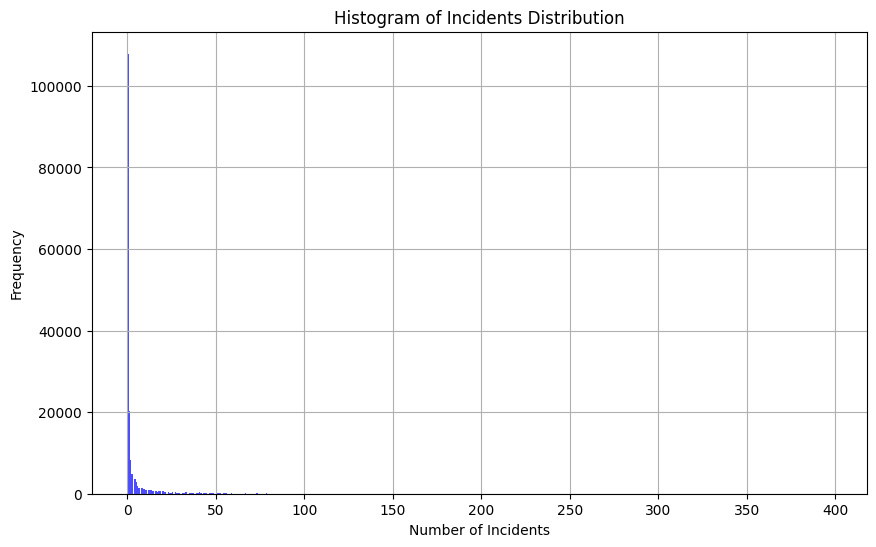

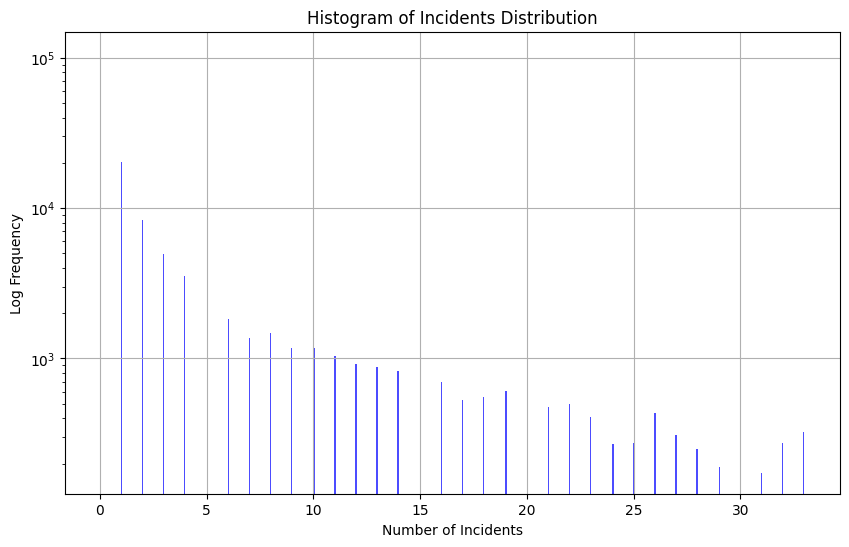

Number of Incidents  Frequency
0                      0     107881
1                      1      20190
2                      2       8300
3                      3       4920
4                      4       3529
..                   ...        ...
174                  166          1
175                  275          1
176                  250          1
177                  184          1
178                  100          1

[179 rows x 2 columns]

In [32]:
import matplotlib.pyplot as plt

# Calculate the interquartile range (IQR)
Q1 = df_with_speed_incidents_sign_crosswalk_complex['Indcidents'].quantile(0.25)
Q3 = df_with_speed_incidents_sign_crosswalk_complex['Indcidents'].quantile(0.95)
IQR = Q3 - Q1

# Calculate the number of observations
n = df_with_speed_incidents_sign_crosswalk_complex['Indcidents'].count()

# Calculate the bin width using the Freedman-Diaconis rule
bin_width = 2 * (IQR / (n ** (1/3)))

# Calculate the total number of bins
bin_number = (df_with_speed_incidents_sign_crosswalk_complex['Indcidents'].max() - df_with_speed_incidents_sign_crosswalk_complex['Indcidents'].min()) / bin_width

# Now plot the histogram with the optimized bin width
plt.figure(figsize=(10, 6))
plt.hist(df_with_speed_incidents_sign_crosswalk_complex['Indcidents'], bins=int(bin_number), color='blue', alpha=0.7)
plt.title('Histogram of Incidents Distribution')
plt.xlabel('Number of Incidents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot with limited x-axis range and log scale for y-axis
plt.figure(figsize=(10, 6))
plt.hist(df_with_speed_incidents_sign_crosswalk_complex['Indcidents'], bins=int(bin_number), color='blue', alpha=0.7, range=(0, Q3 * 1.5))
plt.yscale('log')  # Set y-axis to log scale
plt.title('Histogram of Incidents Distribution')
plt.xlabel('Number of Incidents')
plt.ylabel('Log Frequency')
plt.grid(True)
plt.show()


# Create a DataFrame to count the occurrences of 'Indcidents'
histogram_df = df_with_speed_incidents_sign_crosswalk_complex['Indcidents'].value_counts().reset_index()
histogram_df.columns = ['Number of Incidents', 'Frequency']

# Display the histogram DataFrame
display(histogram_df)

In [ ]:
# df_with_speed_incidents_sign_crosswalk.to_csv('total.csv')
# display(df_with_speed_incidents_sign_crosswalk.head())
# display(df_with_speed_incidents_sign_crosswalk.info())

# df_with_speed_incidents_sign_crosswalk_complex.to_csv('total.csv')
# display(df_with_speed_incidents_sign_crosswalk_complex.head())
# display(df_with_speed_incidents_sign_crosswalk_complex.info())


### Data mining by Classification

In [33]:

df_with_speed_incidents_sign_crosswalk = df_with_speed_incidents_sign_crosswalk_complex.copy()

# incidents_bins = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, np.inf]
#incidents_bins = [-1, 0, 50, 100, 150, 200, 250, 300, 350, np.inf]
incidents_bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, np.inf]

label_encoder = LabelEncoder()
incidents_labels = label_encoder.fit_transform(pd.cut(df_with_speed_incidents_sign_crosswalk['Indcidents'], bins=incidents_bins))
bins = pd.cut(df_with_speed_incidents_sign_crosswalk['Indcidents'], bins=incidents_bins)
df_with_speed_incidents_sign_crosswalk['Indcidents_bin'] = bins.cat.codes

display(df_with_speed_incidents_sign_crosswalk)

# Drop the unrelated column and also the Y related column 
X = df_with_speed_incidents_sign_crosswalk.drop(['geometry', 'Indcidents', 'Indcidents_bin'], axis=1)
y = df_with_speed_incidents_sign_crosswalk['Indcidents_bin']

# Split the data into training and testing sets
# Adjust the test_size as 0.25 for a 75-25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

# print the train and test sets shapes
print(f'The shape of the training set is {X_train.shape}')
print(f'The shape of the testing set is {X_test.shape}')

# print the train and test sets shapes
print(f'The shape of the training set is {X_train.shape}')
print(f'The shape of the testing set is {X_test.shape}')

geometry  SPEED_LIMIT  \
0       POLYGON ((287725.389 5646480.682, 287724.907 5...         40.0   
1       POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0   
2       POLYGON ((287689.401 5646481.723, 287688.919 5...         40.0   
3       POLYGON ((287679.238 5646481.873, 287678.757 5...         40.0   
4       POLYGON ((287719.171 5646387.709, 287718.689 5...         40.0   
...                                                   ...          ...   
225775  POLYGON ((294449.080 5661355.582, 294448.599 5...         70.0   
225776  POLYGON ((294349.193 5661360.331, 294348.712 5...         70.0   
225777  POLYGON ((294249.306 5661365.081, 294248.825 5...         70.0   
225778  POLYGON ((294149.419 5661369.830, 294148.937 5...         70.0   
225779  POLYGON ((294096.484 5661372.347, 294096.003 5...         70.0   

        Indcidents  SIGN_TYPE_Flat_Sheet  SIGN_TYPE_Other  SIGN_TYPE_Varicom  \
0                1                     1                0                  0   
1                1                     1                0                  0   
2                1                     1                0                  0   
3                1                     1                0                  0   
4                0                     0                0                  0   
...            ...                   ...              ...                ...   
225775          46                     7                0                  0   
225776          55                     2                0                  0   
225777          40                     0                0                  0   
225778          31                     0                0                  0   
225779          30                     0                0                  0   

        SIGN_TYPE_LED  SIGN_TYPE_Internally_illuminated  Size_Category_Medium  \
0                   0                                 0                     1   
1                   0                                 0                     1   
2                   0                                 0                     1   
3                   0                                 0                     1   
4                   0                                 0                     0   
...               ...                               ...                   ...   
225775              0                                 0                     2   
225776              0                                 0                     0   
225777              0                                 0                     0   
225778              0                                 0                     0   
225779              0                                 0                     0   

        Size_Category_Large  ...  CROSSWALK_TYPE_ELDERLY  \
0                         0  ...                       0   
1                         0  ...                       0   
2                         0  ...                       0   
3                         0  ...                       0   
4                         0  ...                       0   
...                     ...  ...                     ...   
225775                    5  ...                       0   
225776                    2  ...                       0   
225777                    0  ...                       0   
225778                    0  ...                       0   
225779                    0  ...                       0   

        CROSSWALK_TYPE_RRXING  CROSSWALK_TYPE_PENDING_WO  CROSSWALK_TYPE_STOP  \
0                           0                          0                    0   
1                           0                          0                    0   
2                           0                          0                    0   
3                           0                          0                    0   
4                           0                          0                    0   
...                

The shape of the training set is (128598, 30)
The shape of the testing set is (42866, 30)
The shape of the training set is (128598, 30)
The shape of the testing set is (42866, 30)


In [42]:
# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# setup parameter space
parameters = {'criterion':['gini','entropy'],
              'max_depth':np.arange(1,21).tolist()[0::2],
              'min_samples_split':np.arange(2,11).tolist()[0::2],
              'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}

# create an instance of the grid search object
g1 = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1)

# conduct grid search over the parameter space
g1.fit(X_train,y_train)
cls_params1 = g1.best_params_
print(cls_params1)

# Fit the classifier to the training data
model = g1.best_estimator_
model.fit(X_train, y_train)


# Predict on the test set
model_predictions = model.predict(X_test)

model_accuracy = accuracy_score(y_test, model_predictions)
model_precision = precision_score(y_test, model_predictions, average='macro', zero_division=0)
model_recall = recall_score(y_test, model_predictions, average='macro')
model_f1 = f1_score(y_test, model_predictions, average='macro')
model_proba = model.predict_proba(X_test)
model_roc_auc = roc_auc_score(y_test, model_proba, multi_class='ovo', average='macro') 

print(f'ID3/C4.5 Accuracy: {model_accuracy:.4f}')
print(f'ID3/C4.5 Precision: {model_precision:.4f}')
print(f'ID3/C4.5 Recall: {model_recall:.4f}')
print(f'ID3/C4.5 F1 Score: {model_f1:.4f}')
print(f'ID3/C4.5 ROC AUC: {model_roc_auc:.4f}')
print('')

{'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 25, 'min_samples_split': 2}
ID3/C4.5 Accuracy: 0.6810
ID3/C4.5 Precision: 0.1368
ID3/C4.5 Recall: 0.1083
ID3/C4.5 F1 Score: 0.0895
ID3/C4.5 ROC AUC: 0.6400



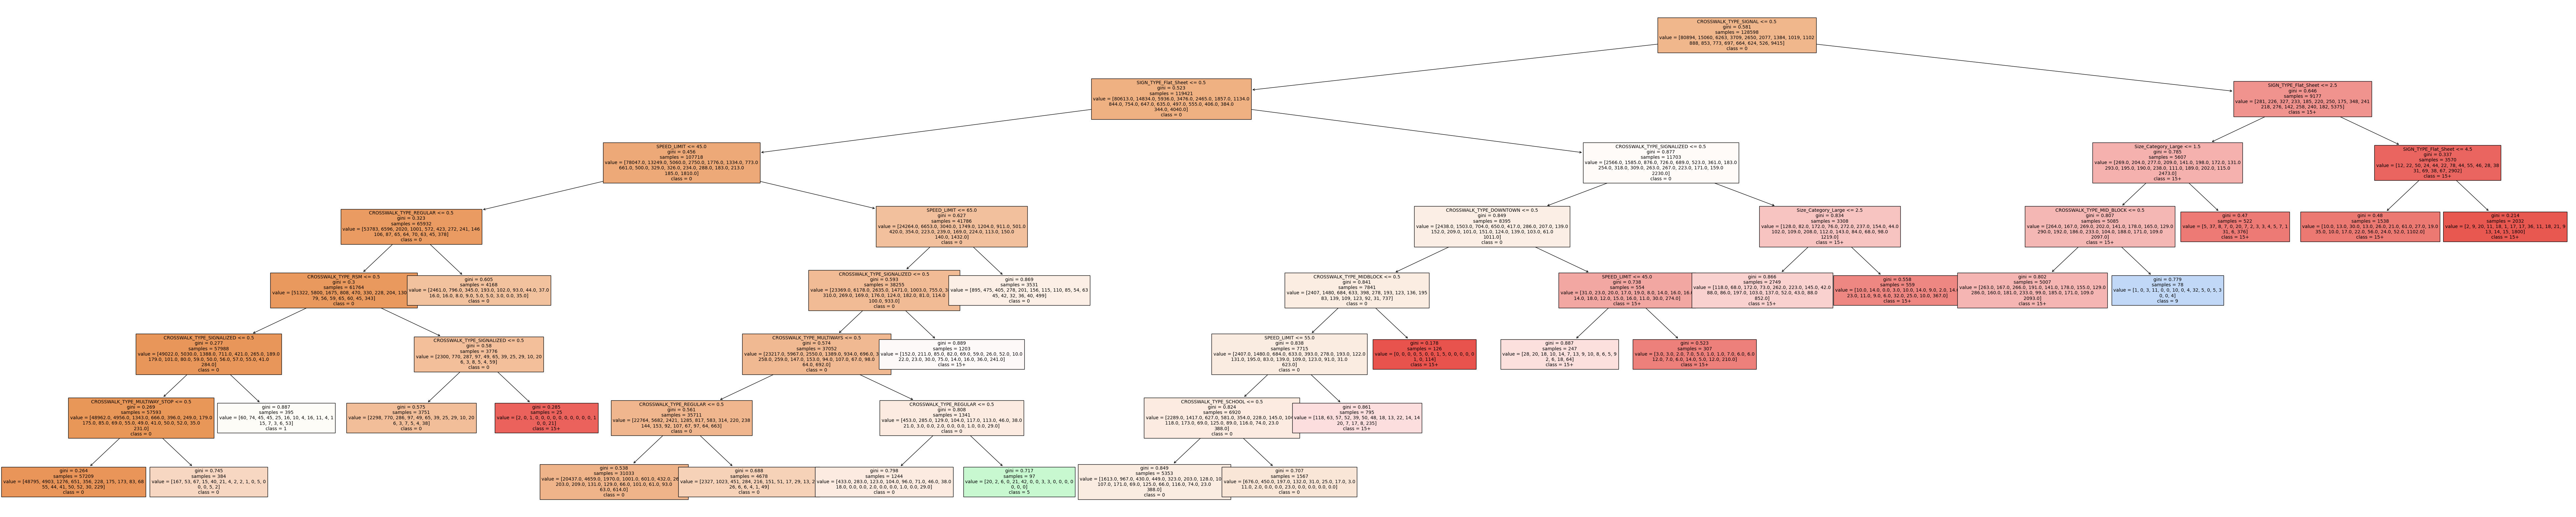

In [43]:
# Define feature names
# feature_names = ['SPEED_LIMIT', 'Sign', 'Crosswalk']
feature_names = ['SPEED_LIMIT', 'SIGN_TYPE_Flat_Sheet', 'SIGN_TYPE_Other', 'SIGN_TYPE_Varicom', 'SIGN_TYPE_LED', 'SIGN_TYPE_Internally_illuminated', 'Size_Category_Medium', 'Size_Category_Large', 'Size_Category_Small', 'CROSSWALK_TYPE_RSM', 'CROSSWALK_TYPE_MULTIWAY_STOP', 'CROSSWALK_TYPE_SIGNALIZED', 'CROSSWALK_TYPE_REGULAR', 'CROSSWALK_TYPE_MID_BLOCK', 'CROSSWALK_TYPE_SIGNAL', 'CROSSWALK_TYPE_SCHOOL', 'CROSSWALK_TYPE_DOWNTOWN', 'CROSSWALK_TYPE_MULTIWAYS', 'CROSSWALK_TYPE_CORRIDOR', 'CROSSWALK_TYPE_MIDBLOCK', 'CROSSWALK_TYPE_RED_LIGHT_CAMERA', 'CROSSWALK_TYPE_ELDERLY_PEDESTRIAN', 'CROSSWALK_TYPE_ELDERLY', 'CROSSWALK_TYPE_RRXING', 'CROSSWALK_TYPE_PENDING_WO', 'CROSSWALK_TYPE_STOP', 'CROSSWALK_TYPE_SPEED_TABLE', 'CROSSWALK_TYPE_TRAFFIC_CIRCLE', 'CROSSWALK_TYPE_OSM', 'CROSSWALK_TYPE_CIRCLE', 'CROSSWALK_TYPE_SPECIAL']
# Define class names
# class_names = ['0', '1-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '350+']
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '15+']

# Plot the decision tree
plt.figure(figsize=(100,20))  # Set figure size (width, height) in inches
plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True, fontsize=10)
plt.savefig('decision_tree_high_res.png', format='png', dpi=300)  # Save to file with high DPI
plt.show()


# viz = dtreeviz.model(model, 
#                X_train,  # Your features matrix (numpy array or pandas dataframe)
#                y_train,  # Your target vector (numpy array, pandas series, or list)
#                target_name='target',  # Name of the target variable
#                feature_names=feature_names, 
#                class_names=class_names)
# # viz.save("decision_tree.svg")  # Saves to an SVG file that you can zoom in on
# viz.view()  # Opens the tree visualization in your default web browser

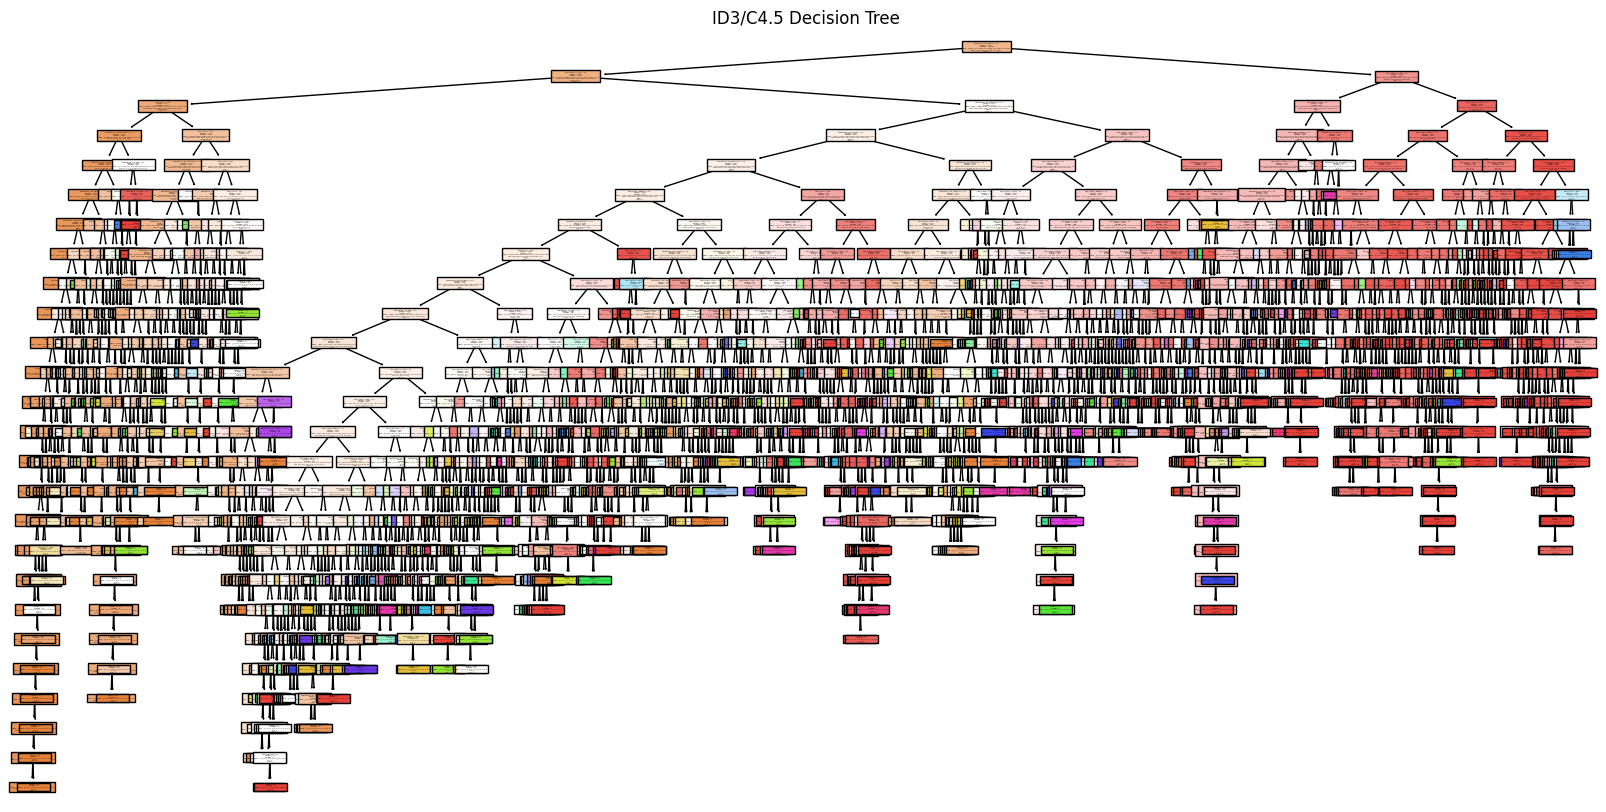

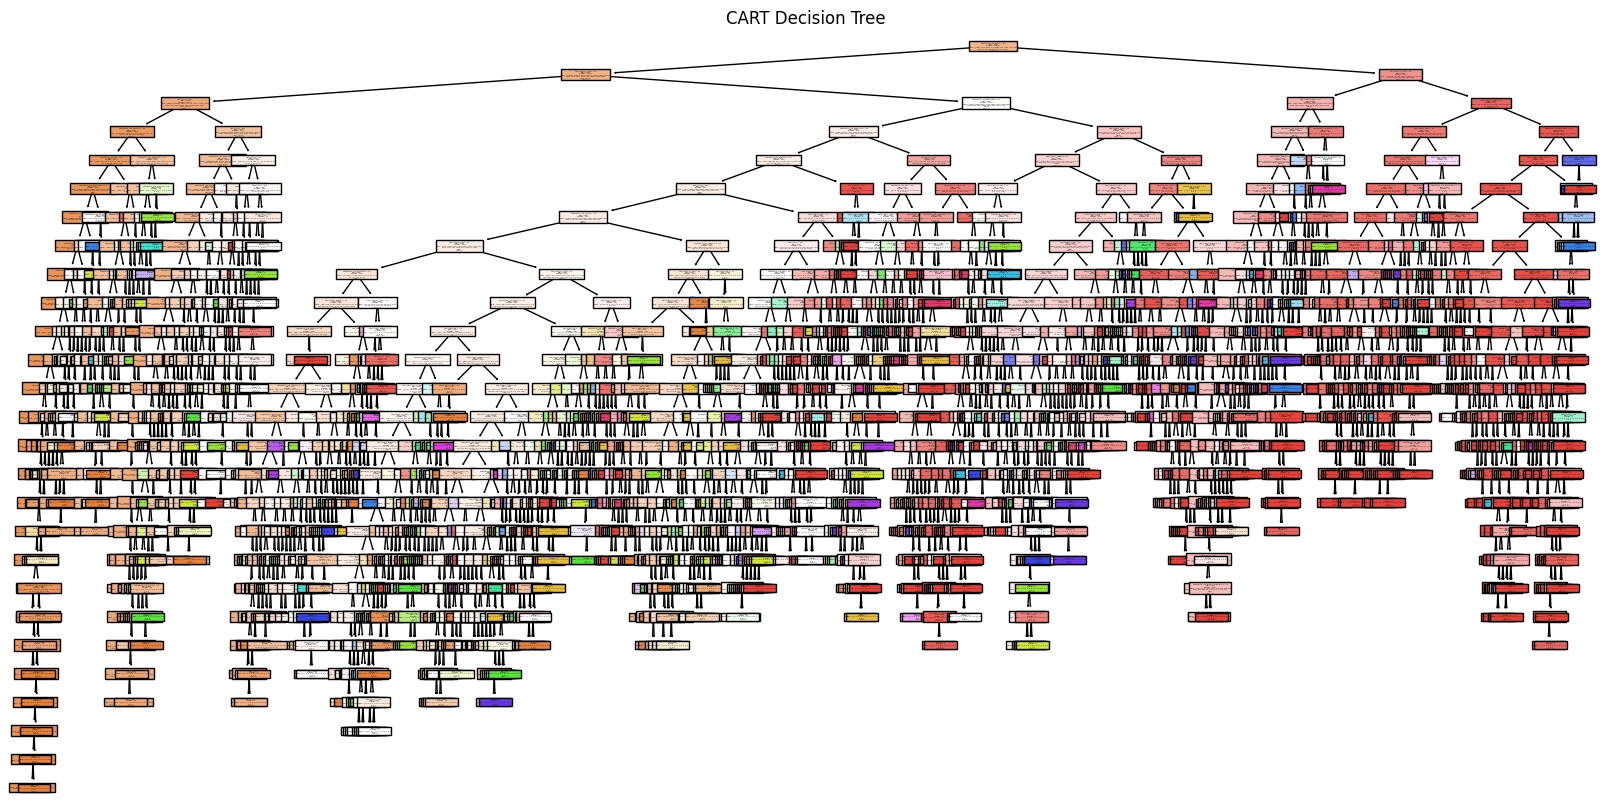

C:\Users\lidou\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [40]:

# collect the evaluation metrics for ID3/C4.5
id3_accuracy = None
id3_precision = None
id3_recall = None
id3_f1 = None
id3_roc_auc = None

# collect the evaluation metrics for CART
CART_accuracy = None
CART_precision = None
CART_recall = None
CART_f1 = None
CART_roc_auc = None

# collect the evaluation metrics for Naive Bayes
NB_accuracy = None
NB_precision = None
NB_recall = None
NB_f1 = None
NB_roc_auc = None

# collect the evaluation metrics for AdaBoost
AdaBoost_accuracy = None
AdaBoost_precision = None
AdaBoost_recall = None
AdaBoost_f1 = None
AdaBoost_roc_auc = None


# Initialize the Decision Tree Classifier with 'entropy' for ID3/C4.5 (Using Decision Trees with 'entropy'):
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
id3_classifier.fit(X_train, y_train)

# Predict on the test set
id3_predictions = id3_classifier.predict(X_test)


id3_accuracy = accuracy_score(y_test, id3_predictions)
id3_precision = precision_score(y_test, id3_predictions, average='macro', zero_division=0)
id3_recall = recall_score(y_test, id3_predictions, average='macro')
id3_f1 = f1_score(y_test, id3_predictions, average='macro')

id3_proba = id3_classifier.predict_proba(X_test)
id3_roc_auc = roc_auc_score(y_test, id3_proba, multi_class='ovo', average='macro') 

# ID3/C4.5 Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(id3_classifier, feature_names=feature_names, class_names=class_names, filled=True)
plt.title('ID3/C4.5 Decision Tree')
plt.savefig('ID3_decision_tree.png')
plt.show()


# Initialize the Decision Tree Classifier with 'gini' for CART (Using Decision Trees with 'gini'):
CART_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
CART_classifier.fit(X_train, y_train)

# Predict on the test set
CART_predictions = CART_classifier.predict(X_test)

CART_accuracy = accuracy_score(y_test, CART_predictions)
CART_precision = precision_score(y_test, CART_predictions, average='macro', zero_division=0)
CART_recall = recall_score(y_test, CART_predictions, average='macro')
CART_f1 = f1_score(y_test, CART_predictions, average='macro')
CART_proba = CART_classifier.predict_proba(X_test)
CART_roc_auc = roc_auc_score(y_test, CART_proba, multi_class='ovo', average='macro') 


# CART Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(CART_classifier, feature_names=feature_names, class_names=class_names, filled=True)
plt.title('CART Decision Tree')
plt.savefig('CART_decision_tree.png')
plt.show()

# Initialize the Naive Bayes Classifier
NB_classifier = GaussianNB()  # Use MultinomialNB if your features are discrete or counts
NB_classifier.fit(X_train, y_train)

# Predict on the test set
NB_predictions = NB_classifier.predict(X_test)

NB_accuracy = accuracy_score(y_test, NB_predictions)
NB_precision = precision_score(y_test, NB_predictions, average='macro', zero_division=0)
NB_recall = recall_score(y_test, NB_predictions, average='macro')
NB_f1 = f1_score(y_test, NB_predictions, average='macro')
NB_proba = NB_classifier.predict_proba(X_test)
NB_roc_auc = roc_auc_score(y_test, NB_proba, multi_class='ovo', average='macro') 

# Initialize the AdaBoost Classifier
AdaBoost_classifier = AdaBoostClassifier(random_state=42)
AdaBoost_classifier.fit(X_train, y_train)

# Predict on the test set
AdaBoost_predictions = AdaBoost_classifier.predict(X_test)

AdaBoost_accuracy = accuracy_score(y_test, AdaBoost_predictions)
AdaBoost_precision = precision_score(y_test, AdaBoost_predictions, average='macro', zero_division=0)
AdaBoost_recall = recall_score(y_test, AdaBoost_predictions, average='macro')
AdaBoost_f1 = f1_score(y_test, AdaBoost_predictions, average='macro')
AdaBoost_proba = AdaBoost_classifier.predict_proba(X_test)
AdaBoost_roc_auc = roc_auc_score(y_test, AdaBoost_proba, multi_class='ovo', average='macro') 

In [41]:
print(f'ID3/C4.5 Accuracy: {id3_accuracy:.4f}')
print(f'ID3/C4.5 Precision: {id3_precision:.4f}')
print(f'ID3/C4.5 Recall: {id3_recall:.4f}')
print(f'ID3/C4.5 F1 Score: {id3_f1:.4f}')
print(f'ID3/C4.5 ROC AUC: {id3_roc_auc:.4f}')
print('')
print(f'CART Accuracy: {CART_accuracy:.4f}')
print(f'CART Precision: {CART_precision:.4f}')
print(f'CART Recall: {CART_recall:.4f}')
print(f'CART F1 Score: {CART_f1:.4f}')
print(f'CART ROC AUC: {CART_roc_auc:.4f}')
print('')
print(f'Naive Bayes Accuracy: {NB_accuracy:.4f}')
print(f'Naive Bayes Precision: {NB_precision:.4f}')
print(f'Naive Bayes Recall: {NB_recall:.4f}')
print(f'Naive Bayes F1 Score: {NB_f1:.4f}')
print(f'Naive Bayes ROC AUC: {NB_roc_auc:.4f}')
print('')
print(f'AdaBoost Accuracy: {AdaBoost_accuracy:.4f}')
print(f'AdaBoost Precision: {AdaBoost_precision:.4f}')
print(f'AdaBoost Recall: {AdaBoost_recall:.4f}')
print(f'AdaBoost F1 Score: {AdaBoost_f1:.4f}')
print(f'AdaBoost ROC AUC: {AdaBoost_roc_auc:.4f}')

ID3/C4.5 Accuracy: 0.6991
ID3/C4.5 Precision: 0.4987
ID3/C4.5 Recall: 0.1904
ID3/C4.5 F1 Score: 0.2308
ID3/C4.5 ROC AUC: 0.7607

CART Accuracy: 0.6994
CART Precision: 0.4991
CART Recall: 0.1911
CART F1 Score: 0.2315
CART ROC AUC: 0.7616

Naive Bayes Accuracy: 0.0445
Naive Bayes Precision: 0.1923
Naive Bayes Recall: 0.1041
Naive Bayes F1 Score: 0.0303
Naive Bayes ROC AUC: 0.6588

AdaBoost Accuracy: 0.6821
AdaBoost Precision: 0.1333
AdaBoost Recall: 0.1082
AdaBoost F1 Score: 0.0912
AdaBoost ROC AUC: 0.6733
